<a href="https://colab.research.google.com/github/jojoroy/MScDis/blob/main/GPMH_LotkaVolterra_sims.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building some intuition about the $L^2$ based risk approach.

The general idea is the following:  we employ a surrogate GP model for the log likelihood of a positive density $\pi$, i.e.
we assume that
$$
    \pi_f(x) = \frac{\exp(f(x))\pi_0(x)}{\int \exp(f(x'))\pi_0(x')\,dx'}.
$$
where $\pi_0$ is a prior distribution which is assumed to be tractable.   We denote by $\widetilde{\pi}_f$ to be the unnormalised posterior distribution.

#### Approach 1:  $L^2$ between unnormalised measures loss.

This is the idea of [Sinsbeck and Nowak](https://epubs.siam.org/doi/abs/10.1137/15M1047659), however it has been adjusted to make it comparable to our approach.  While in their paper they considered a surrogate for the actual forward problem, in this work we surrogate the likelihood directly.   This is directly discussed in [Jarvenpaa et al, 2021](https://projecteuclid.org/journals/bayesian-analysis/volume-16/issue-1/Parallel-Gaussian-Process-Surrogate-Bayesian-Inference-with-Noisy-Likelihood-Evaluations/10.1214/20-BA1200.full), although the focus of that paper is an alternative loss function.   

We wish to derive an optimal estimator for the unnormalised posterior $\widetilde{\pi}_f$ using Bayesian decision theory.  To this end, we consider the integrated quadratic loss function:
$$
    l(\widetilde{\pi}_1, \widetilde{\pi}_2) = \int_{X} |\widetilde{\pi}_1(x) - \widetilde{\pi}_2(x)|^2\,dx,
$$
where we assume that both $\widetilde{\pi}_1$ and $\widetilde{\pi}_2$ are square-integrable.

The optimal bayes estimator is the minimiser of the expected loss, i.e.
$$
\begin{aligned}
    \widetilde{\pi}^* &= \arg\min_{d} \mathbb{E}_{f| D} \int |\widetilde{\pi}_f(x) - d(x)|^2\,dx \\
                      &= \arg\min_{d}  \int \mathbb{E}_{f| D} |\widetilde{\pi}_f(x) - d(x)|^2\,dx
\end{aligned}
$$
The optimal estimator can be derived and shown to be
$$
    \widetilde{\pi}^* =  \mathbb{E}_{f| D}[\widetilde{\pi}_f].
$$

The Bayes risk is the integrated variance;
$$
\int {Var}_{f | D}[\widetilde{\pi}_f(x)]\,dx.
$$

You can derive closed-form expressions for both in the GP case, namely
$$
   \mathbb{E}_{f| D}[\widetilde{\pi}_f] = \pi_0(x)e^{m(x) + s^2(x)},
$$
and
$$
 {Var}_{f | D}[\widetilde{\pi}_f(x)] = \pi_0(x)^2 e^{2m(x) + s^2(x)}(e^{s^2(x)} - 1),
$$
where $m$ and $s$ are the pointwise mean and standard deviation of the conditioned GP $f | D$.  

### Our Proposed Approach

We propose the following iterative scheme

Find $p_n$ such that
$$
    \arg\max_{x} \mathbb{E}_{z \sim f(x)|D}\mathbb{E}_{f|D }D(p_{D \cup \lbrace (x,y)\rbrace } \,|\, p_{D})
$$
Choosing KL divergence we have objective function
$$
\mathbb{E}_{z \sim f(x)|D} \mathbb{E}_{f|D }\int \frac{e^{f_n(x) - k_n(x,x^*)k_n(x^*, x^*)^{-1}z)}}{\int e^{f_n(x') - k_n(x',x^*)k_n(x^*, x^*)^{-1}z)}\,dx'}k_n(x,x^*)k_n(x^*, x^*)^{-1}z\,dx.
$$

With Fisher divergence, we get a similar expression, but with gradients in the integrand.   If we can argue that we can replace $f$ with it's mean, then this simplifies somewhat:
$$
\mathbb{E}_{z \sim f(x)|D} \int \frac{e^{m_n(x) - k_n(x,x^*)k_n(x^*, x^*)^{-1}z)}}{\int e^{m_n(x') - k_n(x',x^*)k_n(x^*, x^*)^{-1}z)}\,dx'}k_n(x,x^*)k_n(x^*, x^*)^{-1}z\,dx.
$$
It is unclear how we can justify this assumption, and further how to cleanly deal with the expectation wrt to $z$.

### Exploring the $L^2$ loss based estimator and its risk.   

We implement the idea of Sinsbeck and Nowak, but adjust it to work in our setting where we have a surrogate for the likelihood directly.

In [1]:
pip install jaxtyping


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.9 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [2]:
pip install gpjax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.6/111.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.1/819.1 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.2/197.2 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 1.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.24.0
    Uninstalling tensorflow-probability-0.24.0:
      Successfully uninstalled tensorflow-probability-0.24.0
  Attempting uninstall: optax
    Found existing installation: optax 0.2.2
    Uninstalling optax-0.2.2:
      Successfully uninstalled optax-0.2.2


In [3]:
# Enable Float64 for more stable matrix inversions.
from jax import config

config.update("jax_enable_x64", True)

from jax import jit
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import install_import_hook
import matplotlib as mpl
import matplotlib.pyplot as plt
import optax as ox

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx

from jax.scipy.special import logsumexp
from jax.scipy.stats import norm as norm
import cola


key = jr.PRNGKey(123)

/usr/local/lib/python3.10/dist-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


In [4]:
import numpy as np
#from jax.scipy.special import log1p

This is just some test code to check that the Gaussian process does regression properly.

In [5]:
kernel = gpx.kernels.RBF()
meanf = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

In [6]:
# Define the negative log marginal likelihood
negative_mll = gpx.objectives.ConjugateMLL(negative=True)
negative_mll = jit(negative_mll)

def fit_gp(x,y, key, do_optimize=True, obs_stddev=1e-3):
    """Fit a GP to the data (x,y) using the negative log marginal likelihood as the objective function.
    Args:
        x: input data
        y: output data
        key: random key
        do_optimize: whether to optimize the hyperparameters
        obs_stddev: observation noise
    Returns:
        posterior: the posterior distribution
    """

    D = gpx.Dataset(x, y)

    kernel = gpx.kernels.RBF()
    meanf = gpx.mean_functions.Zero()
    prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

    likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n,obs_stddev=jnp.array(1e-3))  # Our function is noise-free, so we set the observation noise's standard deviation to a very small value
    likelihood = likelihood.replace_trainable(obs_stddev=False)
    posterior = prior * likelihood
    '''suggestion:<300 points reestimate hyperparameters else every 10'''
    if do_optimize:
        # optimize the hyperparameters using Adam (this isn't great, but it works)
        # TODO: use a better optimizer
        # the optimizer needs optax to work
        opt_posterior, a = gpx.fit(
        model=posterior,
        objective=negative_mll,
        num_iters=1000,
        train_data=D,
        optim=ox.adamw(learning_rate=0.01),safe=True,
        key = key)

        return opt_posterior
    else:
        return posterior


def evaluate_posterior(x,y, x_eval, key, do_optimize=True, obs_stddev=1e-3):
    """Evaluate the posterior predictive distribution at x_eval.
    Args:
        x: input data
        y: output data
        x_eval: points at which to evaluate the posterior predictive distribution
        do_optimize: whether to optimize the hyperparameters
        obs_stddev: observation noise
    Returns:
        predictive_mean: mean of the posterior predictive distribution
        predictive_std: standard deviation of the posterior predictive distribution
    """

    D = gpx.Dataset(x, y)

    posterior = fit_gp(x,y, key, do_optimize=do_optimize, obs_stddev=obs_stddev)


    latent_dist = posterior.predict(x_eval, train_data=D)
    predictive_dist = posterior.likelihood(latent_dist)

    predictive_mean = predictive_dist.mean()
    predictive_std = predictive_dist.stddev()

    return predictive_mean, predictive_std

To select a new point, Sinsbeck and Nowak make use of the L2 risk function (also Jarvenpaa et al, 2021), as follows:

$$
    R(\theta^*) = \mathbb{E}_{y \sim f(x^*) |D}\int e^{2m_t(x; x^*, y) + s_t^2(x; x^*, y)}(e^{s_t^2(x; x^*, y)} - 1),
$$
where $m_t(x; x^*, y)$ is the posterior mean of the GP after conditioning on the current data set $D$ along with an additional point $(x^*, y)$.  The variance $s_t^2(x; x^*, y)$ is defined analogously.

To compute the expectation, we do Monte Carlo using exact samples of $y \sim f(x^*) |D$.  We typically use just $10$ samples.  Unsurprisingly this is very slow, and little bit unstable.

To compute the integral over $x$, we evaluate the gp over a fine mesh and use Euler integration.   This obviously cannot scale beyond a few dimensions.

So can we avoid the need to compute the expectation with respect to y?   

To do so, we follow the approach / derivations in [Jarvenpaa, 2021] which derive closed form distributions for the GP mean and GP variance.  

More specifically we can show that the loss function becomes
$$
        R(\theta^*) = \int e^{2m_t(x) + s_t^2(x)}(e^{\tau_t(x, x^*)} - 1),
$$
where
$$
\tau_t(x, x^*) = \frac{k_t(x, x^*)^2}{s_t(x^*)^2 + \sigma^2},
$$
where $\sigma^2$ is the variance of the observational noise and where

* $k_t$ is the kernel (i.e. two-point covariance) of the GP conditioned on $D$.
* $m_t$ is the mean of the GP conditioned on $D$.
* $s_t^2$ is the variance of the GP conditioned on $D$.

In [7]:
# this computes k_t, the two point covariance function
def two_point_covariance(x_current, X, Y, posterior, jitter=1e-6):
    """Compute the two point covariance function.
    Args:
        x_current: current point
        X: input data
        Y: output data
        posterior: posterior distribution
        jitter: jitter for numerical stability
    Returns:
        covariance: two point covariance function
    """
    kernel = posterior.prior.kernel
    obs_noise = posterior.likelihood.obs_stddev**2

    Kxx = kernel.gram(x_current)
    Kxx += cola.ops.I_like(Kxx) * obs_noise

    #Sigma = Kxx + cola.ops.I_like(Kxx) * obs_noise
    #Sigma = cola.PSD(Sigma)

    KXY = kernel.cross_covariance(X, Y)
    KXx = kernel.cross_covariance(X, x_current)
    KxY = kernel.cross_covariance(x_current, Y)


    Sigma_inv_KxY = cola.solve(Kxx, KxY)

    covariance = KXY - jnp.matmul(KXx, Sigma_inv_KxY)

    return covariance

How do we interpret the loss function?

1. The $\mu_n$ weights points which have mean (exploitation)
2. The $\sigma_n^2$ weights points which have higher absolute variance (exploration).
3. The main term $\tau^2(a,b)$ is large when there's a strong correlation between $a$ and $b$, weighted by their standard deviation.

The tau effectively acts as a "bump" function which aggregates points around the design point.

In summary -- preferred design points will lie in a neighbourhood of large $\mu_n$ or large $\sigma^2_n$, thus effectively performing exploration / exploitation.

### Computational Cost

Every macro step of the algorithm is $O(N^3)$, where $N$ is the number of points evaluated
Within each macro-step you have cost $M*N^2$, where $M$ is the number of MCMC samples generated.

## 2023 paper

In [8]:
# This removes the terms that don't depend on x_new
def loss_2023paper(x_current, y_current, x_new, x_grid, key, obs_stddev=1e-3):
    """Evaluate the L2 risk function at x_new.
    The code is vectorised over x_new, so you can just pass in a full grid of test points to evaluate it at

    This version removes the terms that don't depend on x_new, so it's faster than loss_fast.
    Args:
        x_current: input data
        y_current: output data
        x_new: point(s) at which to evaluate the risk function
        x_grid: points at which to evaluate the posterior predictive distribution
        key: random key
        obs_stddev: observation noise
    Returns:
        risk_value: risk function value
    """
    D = gpx.Dataset(x_current, y_current)

    posterior = fit_gp(x_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)

    latent_dist = posterior.predict(x_new, train_data=D)
    predictive_dist = posterior.likelihood(latent_dist)

    p_mean = predictive_dist.mean()#.reshape(-1,1)
    p_std = predictive_dist.stddev()#.reshape(-1,1)

    C = two_point_covariance(x_current, x_grid, x_new, posterior)
    #print(np.shape(C))


    tau2 = (C[0]-C[1])**2/(p_std**2 + obs_stddev**2)
    # utility_value =  jnp.mean(jnp.exp(2.0*p_mean**2 + p_std**2 - offset)*(jnp.exp(p_std**2) - jnp.exp(tau2)), axis=0)

    #log_loss = -logsumexp(2.0*p_mean + p_std**2 + tau2, axis=0)

    #return(log_loss)
    #print(np.shape(tau2))
    return(tau2)

In [9]:
# This removes the terms that don't depend on x_new
def loss_2023papernew(posterior,x_current, y_current, x_new, x_grid, key, obs_stddev=1e-3):
    """Evaluate the L2 risk function at x_new.
    The code is vectorised over x_new, so you can just pass in a full grid of test points to evaluate it at

    This version removes the terms that don't depend on x_new, so it's faster than loss_fast.
    Args:
        x_current: input data
        y_current: output data
        x_new: point(s) at which to evaluate the risk function
        x_grid: points at which to evaluate the posterior predictive distribution
        key: random key
        obs_stddev: observation noise
    Returns:
        risk_value: risk function value
    """
    #D = gpx.Dataset(x_current, y_current)

    #posterior = fit_gp(x_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)

    latent_dist = posterior.predict(x_new, train_data=D)
    predictive_dist = posterior.likelihood(latent_dist)

    p_mean = predictive_dist.mean()#.reshape(-1,1)
    p_std = predictive_dist.stddev()#.reshape(-1,1)

    C = two_point_covariance(x_current, x_grid, x_new, posterior)
    #print(np.shape(C))


    tau2 = (C[0]-C[1])**2/(p_std**2 + obs_stddev**2)
    # utility_value =  jnp.mean(jnp.exp(2.0*p_mean**2 + p_std**2 - offset)*(jnp.exp(p_std**2) - jnp.exp(tau2)), axis=0)

    #log_loss = -logsumexp(2.0*p_mean + p_std**2 + tau2, axis=0)

    #return(log_loss)
    #print(np.shape(tau2))
    return(tau2)

In [10]:
def epsilon_gamma(m,v,u):
  return norm.cdf(-jnp.abs(m-jnp.log(u)/jnp.sqrt(v)))

In [11]:
def log_epsilon_gamma(m,v,u):
  return norm.logcdf(-jnp.abs(m-jnp.log(u)/jnp.sqrt(v)))

In [12]:
#PRONE TO INSTABILITY
def expected(m,v):
  v1=np.sqrt(v)
  if m>=0:
    return norm.cdf(-m/v1)-jnp.exp(m+(v/2))*norm.cdf(-(m/v1+v1))
  else:
    return norm.cdf(m/v1)+jnp.exp(m+(v/2))*(norm.cdf(-(m/v1+v1))-2*norm.cdf(-v1))

In [13]:
def expected1(m,v):
  u = jnp.arange(0,1,0.05)
  return logsumexp(log_epsilon_gamma(m,v,u))

In [14]:
#make new eval posterior for this situation
def gpmh_eval_posterior1(posterior,x_prop,x_now,key,obs_stddev, D):
  x_eval = jnp.vstack([x_now,x_prop])

  x_eval = x_eval.reshape(-1,1)
  #D = gpx.Dataset(x_current, y_current)

  #posterior = fit_gp(x_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)

  latent_dist = posterior.predict(x_eval, train_data=D)
  predictive_dist = posterior.likelihood(latent_dist)
  m = predictive_dist.mean().reshape(-1,1)
  v = predictive_dist.stddev().reshape(-1,1)
  C = two_point_covariance(x_current, x_eval[0].reshape(-1,1), x_eval[1].reshape(-1,1), posterior)
  #print(m,x_eval)
  return m[1]-m[0],v[0]**2 + v[1]**2 - 2*C

In [15]:
#make new eval posterior for this situation
def gpmh_eval_posterior_2d(posterior,x_current,x_prop,x_now,key,obs_stddev, D):
  x_eval = jnp.vstack((x_now,x_prop))

  #x_eval = x_eval.reshape(-1,1)
  #D = gpx.Dataset(x_current, y_current)

  #posterior = fit_gp(x_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)
  #print( x_eval[0], x_eval[1],x_current)
  latent_dist = posterior.predict(x_eval, train_data=D)
  predictive_dist = posterior.likelihood(latent_dist)
  m = predictive_dist.mean().reshape(-1,1)
  v = predictive_dist.stddev().reshape(-1,1)
  C = two_point_covariance(x_current, jnp.array([x_eval[0]]), jnp.array([x_eval[1]]), posterior)
  #C1 = two_point_covariance(x_current, jnp.array([x_eval[0]]), jnp.array([x_eval[0]]), posterior)
  #C2= two_point_covariance(x_current, jnp.array([x_eval[1]]), jnp.array([x_eval[1]]), posterior)
  #print(v**2,C,C1,C2,posterior.likelihood.obs_stddev**2)
  #print(m,x_eval)
  return m[1]-m[0],v[0]**2 + v[1]**2 - 2*C-2*posterior.likelihood.obs_stddev**2

# thoughts for likelihood
simulate likelihood for the data given different parameters
choosing new points means choosing new parameters to fit the model
if u want the likelihood to be normal

In [ ]:
from jax import vmap
from jax.experimental.ode import odeint

In [ ]:
def lotka_volterra(X, t, alpha, beta, delta, gamma):
    x, y = X
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]

# Vectorized integration function
def integrate_model(params, t, initial_conditions):
    alpha, beta = params
    delta=0.1
    gamma=1.5
    # Define the ODE function for a single set of parameters
    def odefunc(X, t):
        return lotka_volterra(X, t, alpha, beta, delta, gamma)

    # Integrate the ODE
    return odeint(odefunc, initial_conditions, t)

# Vectorized log-likelihood function
@jit
def log_likelihood_lv(params):#, t, data, initial_conditions):
    params=jnp.exp(params)
    # Ensure params are in the correct shape (N, 4) where N is the number of parameter sets
    def integrate_single(params):
        return integrate_model(params, t, initial_conditions)

    # Vectorize integration over parameter sets
    models = vmap(integrate_single)(params)

    # Compute the error and log-likelihood for each parameter set
    errors = data - models

    sigma=10000
    log_likelihoods = -jnp.sum(errors**2, axis=(1, 2)) / (2*sigma) +10.
    return log_likelihoods

# Example data
true_params = jnp.array([2.0, 0.1])
initial_conditions = jnp.array([10.0, 5.0])
t = jnp.linspace(0, 50, 500)
data = integrate_model(true_params, t, initial_conditions)

# Initial guess for parameters
initial_params = jnp.array([[1.0, 0.05], [2.0, 0.1],[1.1,1.1]])

# Compute log-likelihoods for each parameter set
ll_values = log_likelihood_lv(initial_params)#, t, data, initial_conditions)
print("Log-Likelihoods:", ll_values)

Log-Likelihoods: [-11.53813645  -7.59255162 -31.01450342]


In [ ]:
# define x current and y_current
params_current = jnp.array([[1.0, 0.1], [2.0, 0.2], [1.5, 0.3],[0.1,0.1],[2.0,-3.0],[-2.0,-3.0],[-2.0,1.0]])
mean = [0, 0]
cov = [[0.1, 0], [0, 0.1]]

params_current = jnp.array(np.random.multivariate_normal(mean, cov, 20))
params_current = jnp.array(np.random.uniform([-2,-3],[2,1],(30,2)))
params_current=round(params_current,1)
true_params = jnp.array([2.0, 0.1])
initial_conditions = jnp.array([10.0, 5.0])
t = jnp.linspace(0, 50, 500)
#data = generate_synthetic_data(true_params, initial_conditions, t)
y_current = jnp.array(log_likelihood_lv(params_current).reshape(-1,1))
# set up empty mh_samples


In [ ]:
params_current

Array([[-0.3, -2.4],
       [-1.6, -2.5],
       [-0.2, -1.7],
       [ 1. , -3. ],
       [ 1.3, -2.4],
       [-1.1,  0.3],
       [-1.6, -1.7],
       [ 1.9,  0.3],
       [ 1.4, -2.2],
       [-1.8,  0.2],
       [ 1.2, -1.9],
       [ 1.9, -2.5],
       [ 0.3, -0.6],
       [ 1.5, -2.6],
       [ 0.6, -2.6],
       [-0.8,  0.1],
       [-2. , -0.9],
       [-1.7, -1.7],
       [ 1.2,  0.6],
       [ 0.1, -0.2],
       [-0.9, -2.3],
       [ 0.4, -0.5],
       [ 0.5,  0.2],
       [ 0. ,  0.4],
       [-1. , -0.6],
       [-1.6,  0.3],
       [ 1. , -2.7],
       [-0.5, -2.4],
       [ 0.1, -1.8],
       [-0.7,  0.6]], dtype=float64)

In [ ]:
N = 3000
mh_samples=np.zeros((N,2))
mh_samples[0,0]=0.25
mh_samples[0,1]=-0.25
epsilon = 0.25
obs_stddev=1e-3
proposal='uniform'

In [ ]:
from sklearn.metrics import pairwise_distances
def remove_close_rows(arr1, arr2, threshold=1e-6):
    # Compute the distance between each pair of rows
    distances = pairwise_distances(arr1,arr2)
    #print(distances)

    # Check if any distance is below the threshold for each row in arr1
    is_close = jnp.any(distances < threshold, axis=1)

    # Keep rows that are not close to any row in arr2
    result = arr1[~is_close]

    return result



In [ ]:
D = gpx.Dataset(params_current, y_current)
#print(D)
posterior = fit_gp(params_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)
for i in range(1,N):
  # centred around prev step with var 1
  if proposal == 'uniform':
    params_prop = (np.random.uniform(0,1,2) - 0.5)*0.2 + mh_samples[i-1,:]
  else:
    params_prop=(np.random.normal(0,1,2)*0.25 + mh_samples[i-1])
  u = np.random.uniform()
  params_now=mh_samples[i-1]
  # find mean and variance of log likelihood ratio at proposal and prev point
  m,v = gpmh_eval_posterior_2d(posterior,params_current,params_prop,params_now,key,obs_stddev,D)

  print('step',i,log_epsilon_gamma(m,v,u),expected1(m,v),jnp.log(epsilon),'Current',params_now,'proposed',params_prop)

  while expected(m,v) > epsilon:# and np.size(test_points) >5:
  #while (expected1(m,v) > jnp.log(epsilon) or log_epsilon_gamma(m,v,u)>jnp.log(0.1)) and np.size(params_current) < 400:

    obs_stddev = 1e-3
    num_samples= 10

    #x_grid = jnp.arange(-5.0, 5.0, 0.01).reshape(-1, 1)
    params_grid = jnp.vstack([params_now,params_prop])#.reshape(-1,1)

    # how many do you need to set up
    x_range = jnp.arange(start = -3., stop = 3., step = 0.2 )
    y_range = jnp.arange(start = -3., stop = 3., step = 0.2 )

    x_gridvalues, y_gridvalues = jnp.meshgrid(x_range, y_range)
    test_points = jnp.vstack([x_gridvalues.flatten(), y_gridvalues.flatten()]).T
    '''
    max=round(jnp.max(x_grid),1)
    min=round(jnp.min(x_grid),1)

    #get lengthscale
    ls = posterior.prior.kernel.lengthscale
    print('lengthsxale:',ls)
    test_points = jnp.arange(min-round(5*ls,1), round(ls*5,1), 0.1)
    '''
    test_points=remove_close_rows(test_points,params_current)
    test_points= jnp.round(test_points,1)
    ## this remove points done needs work
    #test_points= jnp.array([testpt for testpt in test_points if testpt not in x_current])
    #test_points= jnp.round(test_points,1)
    #print(np.shape(test_points))
    test_point_utilities = loss_2023papernew(posterior,params_current, y_current, test_points,params_grid, key, obs_stddev)

    j = jnp.argmax(jnp.array(test_point_utilities))
    params_new = test_points[j]
    #y_new = l(x_new)
    params_current = jnp.vstack([params_current, params_new])
    y_current = log_likelihood_lv(params_current).reshape(-1,1)
    D = gpx.Dataset(params_current, y_current)

    posterior = fit_gp(params_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)
    m,v = gpmh_eval_posterior_2d(posterior,params_current,params_prop,params_now,key,obs_stddev, D)
    print('chosen new point',params_new,'size',np.shape(params_current),jnp.exp(expected1(m,v)))
  print('m',m,'v',v,u)
  if m >= jnp.log(u):
    mh_samples[i] = params_prop
  else:
    mh_samples[i] = mh_samples[i-1]


  0%|          | 0/1000 [00:00<?, ?it/s]

step 1 [[-89.80950231]] -0.44650493845940675 -1.3862943611198906 Current [ 0.25 -0.25] proposed [ 0.22239867 -0.21861991]
m [-0.48759346] v [[0.00543768]] 0.36612052918856985
step 2 [[-244.06742343]] 0.34473637140542646 -1.3862943611198906 Current [ 0.22239867 -0.21861991] proposed [ 0.16433919 -0.1851829 ]
m [-0.45684992] v [[0.02346804]] 0.03249439078307448
step 3 [[-32.8422465]] -0.4080967023394475 -1.3862943611198906 Current [ 0.16433919 -0.1851829 ] proposed [ 0.08015665 -0.19802275]
m [0.59728479] v [[0.07194545]] 0.14768206474524992
step 4 [[-1.89749724]] 1.1974077469841553 -1.3862943611198906 Current [ 0.08015665 -0.19802275] proposed [ 0.17862358 -0.13657167]


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.2 -0.2] size (31, 2) 2.003624810086038


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [0.2 0. ] size (32, 2) 0.32123408105493695
m [-0.58335769] v [[0.00196958]] 0.8926744624790811
step 5 [[-6.519014]] -0.3626635678441804 -1.3862943611198906 Current [ 0.08015665 -0.19802275] proposed [ 0.08624663 -0.28205341]
m [0.06447833] v [[0.01844437]] 0.6736870762429984
step 6 [[-7.16855638]] -1.0840669807237133 -1.3862943611198906 Current [ 0.08624663 -0.28205341] proposed [ 0.00791421 -0.32940622]
m [0.79630239] v [[0.03951529]] 0.6242320969000402
step 7 [[-85.41721939]] -1.318714971477585 -1.3862943611198906 Current [ 0.00791421 -0.32940622] proposed [-0.06007209 -0.3025867 ]
m [0.77676573] v [[0.02522354]] 0.14810973778469827
step 8 [[-44.15220869]] 0.13531136599094484 -1.3862943611198906 Current [-0.06007209 -0.3025867 ] proposed [-0.06597751 -0.23646291]
m [-0.08514592] v [[0.03120784]] 0.1988726044036948
step 9 [[-2.57416029]] 0.3231118348748012 -1.3862943611198906 Current [-0.06597751 -0.23646291] proposed [-0.10275643 -0.14562673]
m [0.0610787] v [[0.0640

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.2 -0.2] size (33, 2) 0.5432852874564605
m [0.15072903] v [[0.01505834]] 0.5246298257511515
step 11 [[-4.22047834]] -0.7935956846151733 -1.3862943611198906 Current [-0.02423199 -0.06065716] proposed [ 0.01066703 -0.14892574]
m [0.54020167] v [[0.03021958]] 0.7521913508806852
step 12 [[-31.18681233]] -0.19740657114841387 -1.3862943611198906 Current [ 0.01066703 -0.14892574] proposed [ 0.00792117 -0.2351374 ]
m [0.11911249] v [[0.02788656]] 0.2908405972497049
step 13 [[-0.80661761]] 0.3860011606336534 -1.3862943611198906 Current [ 0.00792117 -0.2351374 ] proposed [-0.05054586 -0.1596233 ]


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [0. 0.] size (34, 2) 1.0058814022205314
m [-1.54038371] v [[0.00586109]] 0.9186439837375864
step 14 [[-65.88327911]] 0.14204109176184598 -1.3862943611198906 Current [ 0.00792117 -0.2351374 ] proposed [-0.06077711 -0.1434087 ]
m [-1.96373569] v [[0.00752556]] 0.3196354210475363
step 15 [[-88.57672167]] -0.001852429423992774 -1.3862943611198906 Current [ 0.00792117 -0.2351374 ] proposed [ 0.02046393 -0.1523861 ]
m [-1.13613036] v [[0.00659071]] 0.3162397071469205
step 16 [[-80.0174719]] -3.2690742359988434 -1.3862943611198906 Current [ 0.02046393 -0.1523861 ] proposed [ 0.04088395 -0.22638838]
m [1.03883965] v [[0.00424086]] 0.4779427417097095
step 17 [[-35.99789994]] -1.7331013202578887 -1.3862943611198906 Current [ 0.04088395 -0.22638838] proposed [ 0.06900202 -0.30781531]
m [0.75311256] v [[0.01268302]] 0.4361849051242215
step 18 [[-312.09574448]] -1.0728312001187967 -1.3862943611198906 Current [ 0.06900202 -0.30781531] proposed [ 0.1202197 -0.386565 ]
m [0.28164216] 

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.6 -1. ] size (35, 2) 2.4024487109528465


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.8 -0.4] size (36, 2) 0.475033384327108
m [0.08800956] v [[0.01063109]] 0.46296420438698593
step 57 [[-1.22802812]] -0.9008359381994842 -1.3862943611198906 Current [ 0.69318979 -0.73135105] proposed [ 0.72684784 -0.67838473]
m [-0.00722857] v [[0.00695117]] 0.9550008230479091
step 58 [[-402.17595683]] -1.170901756974857 -1.3862943611198906 Current [ 0.72684784 -0.67838473] proposed [ 0.72571715 -0.73681108]
m [0.1566905] v [[0.00672318]] 0.1002315641558792
step 59 [[-97.36032248]] -0.9968906014324705 -1.3862943611198906 Current [ 0.72571715 -0.73681108] proposed [ 0.73242692 -0.78287283]
m [-0.06744633] v [[0.0054268]] 0.3627420819554563
step 60 [[-2.18717245]] 0.46009002782279573 -1.3862943611198906 Current [ 0.73242692 -0.78287283] proposed [ 0.74110088 -0.86723508]


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.6 -0.6] size (37, 2) 0.5659034692883347
m [0.06535691] v [[0.01323069]] 0.7506903356865322
step 61 [[-9.69723609]] 0.6235446798976849 -1.3862943611198906 Current [ 0.74110088 -0.86723508] proposed [ 0.66392918 -0.85804105]
m [-0.16537804] v [[0.06685872]] 0.35496401625351537
step 62 [[-346.82220435]] -0.5119044803575815 -1.3862943611198906 Current [ 0.66392918 -0.85804105] proposed [ 0.70001785 -0.88131064]
m [0.11556547] v [[0.01624721]] 0.03608049133341029
step 63 [[-2.21431014]] 1.0013005840888067 -1.3862943611198906 Current [ 0.70001785 -0.88131064] proposed [ 0.60036185 -0.80839771]


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.8 -1. ] size (38, 2) 0.9120034263680967
m [-0.82989507] v [[0.00689114]] 0.5891374003352181
step 64 [[-127.03215]] -0.37522193632789425 -1.3862943611198906 Current [ 0.70001785 -0.88131064] proposed [ 0.65216575 -0.97251189]
m [-0.25574273] v [[0.00919366]] 0.2164131161469397
step 65 [[-102.07318399]] -0.44506944218527955 -1.3862943611198906 Current [ 0.65216575 -0.97251189] proposed [ 0.68003613 -1.04084468]
m [0.02166938] v [[0.01462872]] 0.18359043921960327
step 66 [[-354.34962978]] -1.5708700120669283 -1.3862943611198906 Current [ 0.68003613 -1.04084468] proposed [ 0.76413469 -1.00307571]
m [0.31877582] v [[0.00564142]] 0.14033810927304324
step 67 [[-1.84962776]] 0.1963665941485121 -1.3862943611198906 Current [ 0.76413469 -1.00307571] proposed [ 0.77845366 -1.0616321 ]
m [-0.48718064] v [[0.01665352]] 0.8247742249106004
step 68 [[-1.01162163]] 0.5766215636195278 -1.3862943611198906 Current [ 0.76413469 -1.00307571] proposed [ 0.70248092 -1.08571916]


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.8 -1.2] size (39, 2) 0.04904739832189239
m [0.71052925] v [[0.00275323]] 0.8471365175443358
step 69 [[-81.87458379]] -0.36673937387138444 -1.3862943611198906 Current [ 0.70248092 -1.08571916] proposed [ 0.60345513 -1.0939071 ]
m [-0.27649368] v [[0.00895028]] 0.2979065610905348
step 70 [[-2.15674689]] -0.6953047490094539 -1.3862943611198906 Current [ 0.60345513 -1.0939071 ] proposed [ 0.60106874 -1.04923277]
m [-0.60444615] v [[0.00321204]] 0.9029547133297777
step 71 [[-8.35712284]] 0.2847866601960919 -1.3862943611198906 Current [ 0.60345513 -1.0939071 ] proposed [ 0.52719388 -1.07811075]
m [-0.91032617] v [[0.01287705]] 0.606409145695459
step 72 [[-7.73970568]] -1.1557493515294772 -1.3862943611198906 Current [ 0.60345513 -1.0939071 ] proposed [ 0.56677727 -1.16145827]
m [0.63418621] v [[0.02171332]] 0.6722341665363454
step 73 [[-0.72938079]] 0.549298476495853 -1.3862943611198906 Current [ 0.56677727 -1.16145827] proposed [ 0.47704491 -1.19649864]
m [-0.20344602] v

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.2 -1.2] size (40, 2) 1.0240259494759867
m [-0.54521768] v [[0.01082323]] 0.7472136616291298
step 96 [[-202.55629746]] -0.4239248258330407 -1.3862943611198906 Current [ 0.45424834 -1.32795171] proposed [ 0.37258995 -1.36899419]
m [-0.11178301] v [[0.01136566]] 0.11802411775498445
step 97 [[-1.05993918]] -0.10896941876678956 -1.3862943611198906 Current [ 0.37258995 -1.36899419] proposed [ 0.34986803 -1.33051711]
m [-0.45937577] v [[0.00953577]] 0.993718764515384
step 98 [[-24.0951146]] 0.9046266324502492 -1.3862943611198906 Current [ 0.37258995 -1.36899419] proposed [ 0.3084683  -1.28597124]
m [-1.47234989] v [[0.05324611]] 0.15801448764131443
step 99 [[-7.81379362]] -1.65345198021677 -1.3862943611198906 Current [ 0.3084683  -1.28597124] proposed [ 0.30722855 -1.34178293]
m [0.74602931] v [[0.01392984]] 0.7354095211338961
step 100 [[-14.15069352]] 0.2556853208195239 -1.3862943611198906 Current [ 0.30722855 -1.34178293] proposed [ 0.39324781 -1.25667729]
m [-0.2586949

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.8 -1.6] size (41, 2) 8.322656475125992e-05
m [2.57807864] v [[0.00186465]] 0.9289611308797878
step 131 [[-510.9826827]] -4.725288644771775 -1.3862943611198906 Current [ 0.60283499 -1.38118405] proposed [ 0.51390715 -1.40264713]
m [1.89798859] v [[0.00902284]] 0.058234096321107987
step 132 [[-4.8813532]] -0.46830059586113837 -1.3862943611198906 Current [ 0.51390715 -1.40264713] proposed [ 0.41558561 -1.42724957]
m [-0.34839804] v [[0.00672226]] 0.7964009050762718
step 133 [[-14.12023724]] -5.945174904008638 -1.3862943611198906 Current [ 0.51390715 -1.40264713] proposed [ 0.45648721 -1.48956945]
m [2.32160372] v [[0.00967809]] 0.7825024688625868
step 134 [[-805.42187406]] -0.39385765261230393 -1.3862943611198906 Current [ 0.45648721 -1.48956945] proposed [ 0.51358365 -1.44956635]
m [-0.6940456] v [[0.00419623]] 0.07154646882501903
step 135 [[-19.25554416]] -0.005262661942898816 -1.3862943611198906 Current [ 0.51358365 -1.44956635] proposed [ 0.54934793 -1.37959983]
m

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.6 -2. ] size (42, 2) 0.046303084472677544
m [1.37059261] v [[0.01232397]] 0.5100455064146474
step 199 [[-126.24128803]] -1.1207856667833096 -1.3862943611198906 Current [ 0.51581526 -1.7100973 ] proposed [ 0.47091872 -1.67802736]
m [-0.33715494] v [[0.00290443]] 0.4223344986416896
step 200 [[-17.9563749]] -0.44255958240082593 -1.3862943611198906 Current [ 0.47091872 -1.67802736] proposed [ 0.43888269 -1.6362681 ]
m [-1.23734834] v [[0.00265003]] 0.7057948321182956
step 201 [[-160.91634557]] -2.470159714765898 -1.3862943611198906 Current [ 0.47091872 -1.67802736] proposed [ 0.52159562 -1.66205923]
m [-0.1031115] v [[0.00118782]] 0.5409091914710469
step 202 [[-2.1174939]] -0.202184379607926 -1.3862943611198906 Current [ 0.52159562 -1.66205923] proposed [ 0.58854984 -1.63884645]
m [-2.04505786] v [[0.00375341]] 0.9479943181884927
step 203 [[-119.86781089]] -2.371347873723542 -1.3862943611198906 Current [ 0.52159562 -1.66205923] proposed [ 0.53984122 -1.69040823]
m [-0.

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.4 -1.8] size (43, 2) 6.18986241419799e-05
m [2.64356461] v [[0.00184057]] 0.9955001620017492
step 276 [[-230.54061731]] -11.002181458761612 -1.3862943611198906 Current [ 0.63474222 -1.87959353] proposed [ 0.56147353 -1.96423949]
m [3.51678609] v [[0.00638074]] 0.24184664573104253
step 277 [[-3807.27149968]] -4.853835454241285 -1.3862943611198906 Current [ 0.56147353 -1.96423949] proposed [ 0.53409002 -1.99492239]
m [1.18926719] v [[0.00172899]] 0.027976172581002157
step 278 [[-95.45180804]] -3.3649426224737646 -1.3862943611198906 Current [ 0.53409002 -1.99492239] proposed [ 0.46384957 -2.05548788]
m [1.48321803] v [[0.01203395]] 0.26588718589624893
step 279 [[-49.70392359]] -1.7644180909053397 -1.3862943611198906 Current [ 0.46384957 -2.05548788] proposed [ 0.5619847  -2.03534107]
m [0.7989882] v [[0.01372779]] 0.3547331469222861
step 280 [[-26.65064201]] -1.255317357721784 -1.3862943611198906 Current [ 0.5619847  -2.03534107] proposed [ 0.639466   -2.05151418]
m [

  0%|          | 0/1000 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
step 500 [[-229.7437216]] -7.121186531615845 -1.3862943611198906 Current [ 0.75431053 -2.1159233 ] proposed [ 0.71458198 -2.13688503]
m [0.72684236] v [[0.00044695]] 0.6479979013382375
step 501 [[-218.7778093]] -0.7418283978165678 -1.3862943611198906 Current [ 0.71458198 -2.13688503] proposed [ 0.72334434 -2.07050692]
m [-1.92826719] v [[0.00134055]] 0.4362554830402665
step 502 [[-491.84388019]] -0.6989121246946464 -1.3862943611198906 Current [ 0.71458198 -2.13688503] proposed [ 0.64432905 -2.0882146 ]
m [-3.32583155] v [[0.0012592]] 0.29345777182471955
step 503 [[-83.15690426]] -1.4063685729771156 -1.3862943611198906 Current [ 0.71458198 -2.13688503] proposed [ 0.78928658 -2.14893881]
m [-0.92225426] v [[0.00098283]] 0.6539595813780114
step 504 [[-325.98272121]] -1.3856356649313362 -1.3862943611198906 Current [ 0.71458198 -2.13688503] proposed [ 0.78804452 -2.14427752]
m [-0.97372111] v [[0.00094344]] 0.4452271564774015
step 505 [[-20

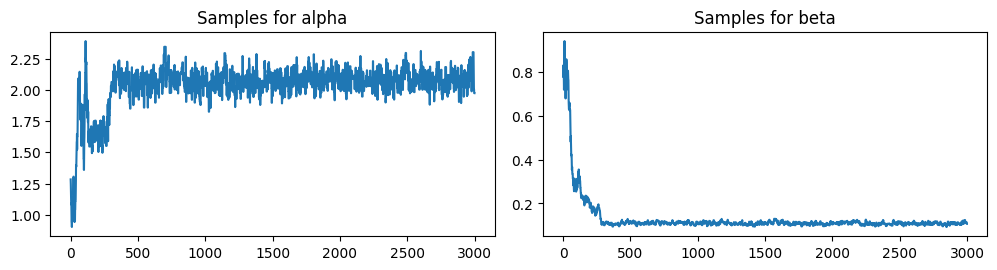

In [ ]:
# Plot the results
plt.figure(figsize=(10, 5))
for i, param in enumerate(['alpha', 'beta']):
    plt.subplot(2, 2, i + 1)
    plt.plot(jnp.exp(mh_samples[:,i]))
    plt.title(f'Samples for {param}')
    #plt.ylim((0,5))
plt.tight_layout()
plt.show()

In [ ]:
i=500
q1=np.quantile(mh_samples[i:,:], 0.05, axis=0)
q3=np.quantile(mh_samples[i:,:], 0.95, axis=0)
q2=np.quantile(mh_samples[i:,:], 0.5, axis=0)

In [ ]:
print(q1,q2,q3)

[ 0.66946291 -2.30429311] [ 0.72851617 -2.21595741] [ 0.7922108  -2.11281488]


In [ ]:
jnp.array([q1])

Array([[ 0.66946291, -2.30429311]], dtype=float64)

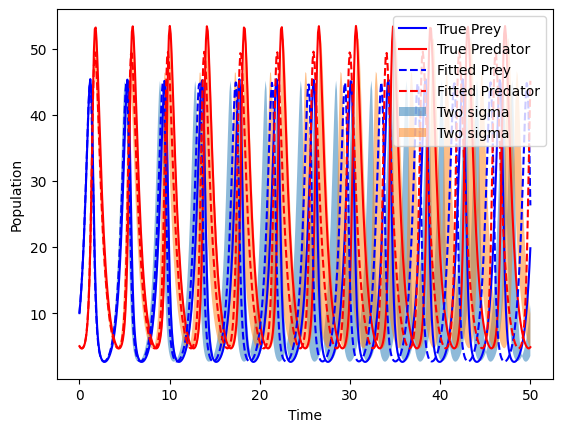

In [ ]:
fitted_model = integrate_model(np.exp(jnp.array(q2)), t, initial_conditions)
fitted_model1 = integrate_model(np.exp(jnp.array(q1)), t, initial_conditions)
fitted_model3 = integrate_model(np.exp(jnp.array(q3)), t, initial_conditions)


plt.figure()
plt.plot(t, data[:, 0], 'b-', label='True Prey')
plt.plot(t, data[:, 1], 'r-', label='True Predator')
plt.plot(t, fitted_model[:, 0], 'b--', label='Fitted Prey')
plt.plot(t, fitted_model[:, 1], 'r--', label='Fitted Predator')
plt.fill_between(
    t,
    fitted_model1[:, 0],
    fitted_model3[:, 0],
    alpha=0.5,
    label="Two sigma",
)
plt.fill_between(
    t,
    fitted_model1[:, 1],
    fitted_model3[:, 1],
    alpha=0.5,
    label="Two sigma",
)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Population')
plt.show()

In [ ]:
def gpmh_eval_posterior_2d_new(posterior,x_prop,x_now,m_now,v_now,key,obs_stddev, D):
  x_eval = jnp.vstack([x_now,x_prop])

  #x_eval = x_eval
  #D = gpx.Dataset(x_current, y_current)

  #posterior = fit_gp(x_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)

  latent_dist = posterior.predict(jnp.array([x_eval[1]]), train_data=D)

  predictive_dist = posterior.likelihood(latent_dist)

  m = predictive_dist.mean().reshape(-1,1)
  v = predictive_dist.stddev().reshape(-1,1)
  #C = two_point_covariance(x_current, x_eval[0].reshape(-1,1), x_eval[1].reshape(-1,1), posterior)
  #print(m,x_eval,v)
  return m,v

def get_it_2d(posterior,x_current,x_prop,x_now,m_now,v_now,key,obs_stddev, D,m,v):
  x_eval = jnp.vstack([x_now,x_prop])

  #x_eval = x_eval.reshape(-1,1)
  C = two_point_covariance(x_current, jnp.array([x_eval[0]]), jnp.array([x_eval[1]]), posterior)
  #C1 = two_point_covariance(x_current, jnp.array([x_eval[0]]), jnp.array([x_eval[0]]), posterior)
  #C2 = two_point_covariance(x_current, jnp.array([x_eval[1]]), jnp.array([x_eval[1]]), posterior)
  #print(C,C1,C2,v_now**2-posterior.likelihood.obs_stddev**2,v**2-posterior.likelihood.obs_stddev**2)
  #print(m,x_eval)
  return m-m_now,v**2 + v_now**2 - 2*C-2*posterior.likelihood.obs_stddev**2

In [ ]:
D = gpx.Dataset(params_current, y_current)
#print(D)
posterior = fit_gp(params_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)
latent_dist = posterior.predict(jnp.array([mh_samples[0]]), train_data=D)
predictive_dist = posterior.likelihood(latent_dist)
m_now = predictive_dist.mean()
v_now = predictive_dist.stddev()
for i in range(1,N):
  # centred around prev step with var 1
  if proposal == 'uniform':
    params_prop = (np.random.uniform(0,1,2) - 0.5)*0.25 + mh_samples[i-1,:]
  else:
    params_prop=(np.random.normal(0,1,2)*0.25 + mh_samples[i-1])
  u = np.random.uniform()
  params_now=mh_samples[i-1]
  # find mean and variance of log likelihood ratio at proposal and prev point
  m_prop,v_prop = gpmh_eval_posterior_2d_new(posterior,x_prop,x_now,m_now,v_now,key,obs_stddev,D)
  m,v=get_it_2d(posterior,params_current,x_prop,x_now,m_now,v_now,key,obs_stddev,D,m_prop,v_prop)

  print('step',i,log_epsilon_gamma(m,v,u),expected1(m,v),jnp.log(epsilon),'Current',params_now,'proposed',params_prop)

  while expected1(m,v) > jnp.log(epsilon):# and np.size(test_points) >5:
  #while (expected1(m,v) > jnp.log(epsilon) or log_epsilon_gamma(m,v,u)>jnp.log(0.1)) and np.size(params_current) < 400:

    obs_stddev = 1e-3
    num_samples= 10

    #x_grid = jnp.arange(-5.0, 5.0, 0.01).reshape(-1, 1)
    params_grid = jnp.vstack([params_now,params_prop])#.reshape(-1,1)

    # how many do you need to set up
    x_range = jnp.arange(start = -3., stop = 3., step = 0.2 )
    y_range = jnp.arange(start = -3., stop = 3., step = 0.2 )

    x_gridvalues, y_gridvalues = jnp.meshgrid(x_range, y_range)
    test_points = jnp.vstack([x_gridvalues.flatten(), y_gridvalues.flatten()]).T
    '''
    max=round(jnp.max(x_grid),1)
    min=round(jnp.min(x_grid),1)

    #get lengthscale
    ls = posterior.prior.kernel.lengthscale
    print('lengthsxale:',ls)
    test_points = jnp.arange(min-round(5*ls,1), round(ls*5,1), 0.1)
    '''
    test_points=remove_close_rows(test_points,params_current)
    test_points= jnp.round(test_points,1)
    ## this remove points done needs work
    #test_points= jnp.array([testpt for testpt in test_points if testpt not in x_current])
    #test_points= jnp.round(test_points,1)
    #print(np.shape(test_points))
    test_point_utilities = loss_2023papernew(posterior,params_current, y_current, test_points,params_grid, key, obs_stddev)

    j = jnp.argmax(jnp.array(test_point_utilities))
    params_new = test_points[j]
    #y_new = l(x_new)
    params_current = jnp.vstack([params_current, params_new])
    y_current = log_likelihood_lv(params_current).reshape(-1,1)
    D = gpx.Dataset(params_current, y_current)

    posterior = fit_gp(params_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)
    m_prop,v_prop = gpmh_eval_posterior_2d_new(posterior,x_prop,x_now,m_now,v_now,key,obs_stddev,D)
    m,v=get_it_2d(posterior,params_current,x_prop,x_now,m_now,v_now,key,obs_stddev,D,m_prop,v_prop)
    print('chosen new point',params_new,'size',np.shape(params_current),jnp.exp(expected1(m,v)))
  print('m',m,'v',v,u)
  if m >= jnp.log(u):
    mh_samples[i] = params_prop
  else:
    mh_samples[i] = mh_samples[i-1]


  0%|          | 0/1000 [00:00<?, ?it/s]

step 1 [[-17.15498623]] -1.3275304271269133 -1.3862943611198906 Current [0. 0.] proposed [-0.11594337 -0.05713643]


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [0.2 0.2] size (68, 2) 0.15440890801663212
m [-6.7742674] v [[4.33337519e-05]] 0.6316384141091727
step 2 [[-645.6210039]] -1.2435981158050895 -1.3862943611198906 Current [0. 0.] proposed [-0.10640078 -0.03640495]


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.4  0. ] size (69, 2) 1.3586383475942966e-05
m [-6.78771413] v [[2.18085369e-05]] 0.681068358916635
step 3 [[-3230.31995515]] -12.386199369702137 -1.3862943611198906 Current [0. 0.] proposed [-0.11352913 -0.01391993]
m [-8.67467542] v [[1.52598172e-05]] 0.7063699171856646
step 4 [[-13.67514249]] -27.269973199605037 -1.3862943611198906 Current [0. 0.] proposed [-0.06718975 -0.06868105]
m [-2.0929621] v [[3.19332871e-05]] 0.9622048842898874
step 5 [[-5857.89332428]] -37.954349184842 -1.3862943611198906 Current [0. 0.] proposed [-0.02492141 -0.08450229]
m [0.89876896] v [[4.73305669e-05]] 0.4780126724546542
step 6 [[-8843.8147563]] -44.81726763564793 -1.3862943611198906 Current [-0.02492141 -0.08450229] proposed [-0.06592126 -0.14964138]
m [-0.81852422] v [[2.65849264e-05]] 0.5017144414852772
step 7 [[-12756.25672374]] -1.1501571468502507 -1.3862943611198906 Current [-0.02492141 -0.08450229] proposed [-0.13313994  0.00302514]


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [0.4 0.4] size (70, 2) 0.0007712339524128244
m [-19.13561748] v [[5.3099626e-05]] 0.23370431451694262
step 8 [[-21.53009288]] -4.0204651169602945 -1.3862943611198906 Current [-0.02492141 -0.08450229] proposed [-0.10927486 -0.20841868]
m [-2.10060467] v [[0.00014924]] 0.904369991154633
step 9 [[-1816.65873052]] -68.50844473645301 -1.3862943611198906 Current [-0.02492141 -0.08450229] proposed [-0.06183059 -0.07672972]
m [-3.01492037] v [[1.26361451e-05]] 0.7987637953330419
step 10 [[-106414.48357245]] -20.053043156212375 -1.3862943611198906 Current [-0.02492141 -0.08450229] proposed [-0.07679908 -0.06436632]
m [-5.17352965] v [[2.15026533e-05]] 0.11496028739773223
step 11 [[-9566.24934174]] -5.304401065376108 -1.3862943611198906 Current [-0.02492141 -0.08450229] proposed [-0.10194899 -0.03271762]
m [-10.64614046] v [[4.04172728e-05]] 0.3879887620770135
step 12 [[-10238.09187641]] -6.50560380499739 -1.3862943611198906 Current [-0.02492141 -0.08450229] proposed [0.00098521

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [0. 0.] size (71, 2) 6.62769524931122e-40
m [5.91707851] v [[5.00299053e-05]] 0.8060222990454329
step 17 [[-5596.14508965]] -1.892002745688012 -1.3862943611198906 Current [-0.11150263 -0.27971677] proposed [-0.19624012 -0.19890122]
m [-6.68187661] v [[0.00037542]] 0.11323541107233692
step 18 [[-1924.69296002]] -168.0846478789797 -1.3862943611198906 Current [-0.11150263 -0.27971677] proposed [-0.21492742 -0.38613676]
m [14.02079661] v [[0.00015616]] 0.5493076370286777
step 19 [[-43.94451816]] -3.0025762419725184 -1.3862943611198906 Current [-0.21492742 -0.38613676] proposed [-0.10987315 -0.35336767]
m [-6.19368032] v [[0.00017568]] 0.8172246362435679
step 20 [[-18740.06306833]] -53.61316140778437 -1.3862943611198906 Current [-0.21492742 -0.38613676] proposed [-0.25444336 -0.39981738]
m [1.47768032] v [[3.59059906e-05]] 0.3163128629686536
step 21 [[-22715.87911856]] -61.21132532317508 -1.3862943611198906 Current [-0.25444336 -0.39981738] proposed [-0.31554508 -0.49942429

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.4 -0.4] size (72, 2) 0.4326563628193557


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.2 -0.8] size (73, 2) 2.5494518988806903e-16
m [-26.80080683] v [[9.10873313e-06]] 0.7649823383346711
step 24 [[-667.28280001]] -701.1478723566947 -1.3862943611198906 Current [-0.31554508 -0.49942429] proposed [-0.25420775 -0.53453281]
m [28.00452657] v [[3.02808837e-05]] 0.9548106296183125
step 25 [[-16765.20933049]] -1.0668236664184108 -1.3862943611198906 Current [-0.25420775 -0.53453281] proposed [-0.29762746 -0.4617585 ]


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.2 -0.6] size (74, 2) 3.228753958820053e-10
m [-21.84547759] v [[1.07193755e-05]] 0.4495821173222396
step 26 [[-7821.84853021]] -15.238171215207913 -1.3862943611198906 Current [-0.25420775 -0.53453281] proposed [-0.28305592 -0.45743307]
m [-20.00515706] v [[1.77068432e-05]] 0.5431902461914159
step 27 [[-140287.46357056]] -2.2359264948630186 -1.3862943611198906 Current [-0.25420775 -0.53453281] proposed [-0.34586546 -0.53814476]
m [-12.87769872] v [[1.94369208e-05]] 0.09144750564861748
step 28 [[-150828.85473858]] -6.305958958548257 -1.3862943611198906 Current [-0.25420775 -0.53453281] proposed [-0.26792602 -0.47250718]
m [-14.56918861] v [[1.93441871e-05]] 0.08377155875230335
step 29 [[-21045.51953428]] -78.65119716392785 -1.3862943611198906 Current [-0.25420775 -0.53453281] proposed [-0.13396056 -0.52011774]
m [7.38253062] v [[0.00011035]] 0.1252642249882978
step 30 [[-4226.20592061]] -91.96169745363663 -1.3862943611198906 Current [-0.13396056 -0.52011774] proposed

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.4 -0.8] size (75, 2) 2.7324147818400183e-24
m [-4.68187259] v [[1.20392656e-05]] 0.16579087498213885
step 33 [[-184.52852568]] -42.75024972663752 -1.3862943611198906 Current [-0.27437747 -0.70328292] proposed [-0.15557343 -0.80158222]
m [-0.86662699] v [[2.75648466e-05]] 0.9009108490041862
step 34 [[-218715.21808937]] -251.92346983430298 -1.3862943611198906 Current [-0.27437747 -0.70328292] proposed [-0.26532398 -0.75227983]
m [2.22393478] v [[6.54956971e-06]] 0.18509143969273922
step 35 [[-2369.79963448]] -92.82221429335418 -1.3862943611198906 Current [-0.26532398 -0.75227983] proposed [-0.29394656 -0.67137034]
m [-6.267833] v [[6.82616269e-06]] 0.8219706943764751
step 36 [[-118464.292585]] -16.638121573290938 -1.3862943611198906 Current [-0.26532398 -0.75227983] proposed [-0.15614877 -0.69863692]
m [-5.0782719] v [[2.44497725e-05]] 0.0878721631833963
step 37 [[-3184.90614821]] -3.3289916053411264 -1.3862943611198906 Current [-0.26532398 -0.75227983] proposed [-0.

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.  -1.2] size (76, 2) 5.514963715391048e-30
m [4.8927191] v [[6.37837502e-05]] 0.7649384099973829
step 59 [[-99.58382311]] -2.721264104934275 -1.3862943611198906 Current [-0.31899275 -0.86496532] proposed [-0.43181329 -0.95683037]
m [-27.0735487] v [[0.00131611]] 0.6191461932597727
step 60 [[-55019.22418671]] -18.607988317050417 -1.3862943611198906 Current [-0.31899275 -0.86496532] proposed [-0.21403123 -0.91788031]
m [-0.3810865] v [[7.2468427e-05]] 0.059192866310349146
step 61 [[-0.79937111]] -1.5142967384210155 -1.3862943611198906 Current [-0.21403123 -0.91788031] proposed [-0.14558647 -0.84162324]
m [-7.1385412] v [[4.20410729e-05]] 0.9555535139022855
step 62 [[-172.58555451]] -59.42715746809669 -1.3862943611198906 Current [-0.21403123 -0.91788031] proposed [-0.10399042 -1.0068116 ]
m [8.36533556] v [[0.00052869]] 0.7944776539273204
step 63 [[-196.73368339]] -69.44406531854875 -1.3862943611198906 Current [-0.10399042 -1.0068116 ] proposed [-0.22518986 -1.1091128

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.2 -1.2] size (77, 2) 0.3025979453264733


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.4 -1. ] size (78, 2) 1.1527871185496671e-08
m [-2.41299928] v [[4.11057918e-05]] 0.6106629846475846
step 66 [[-300.61758834]] -1.5839434924197955 -1.3862943611198906 Current [-0.27242566 -1.20767754] proposed [-0.1922632  -1.26249525]
m [-17.50794506] v [[0.0003781]] 0.4431046669692613
step 67 [[-2095.70315243]] -63.25342315890581 -1.3862943611198906 Current [-0.27242566 -1.20767754] proposed [-0.31880203 -1.22982268]
m [5.96356814] v [[0.00010588]] 0.5466149492401653
step 68 [[-31.26677125]] -2.47070446861154 -1.3862943611198906 Current [-0.31880203 -1.22982268] proposed [-0.29553348 -1.11929466]
m [-9.47921028] v [[0.00022197]] 0.7762039809840175
step 69 [[-210.57717736]] -2.2367861692753603 -1.3862943611198906 Current [-0.31880203 -1.22982268] proposed [-0.28838191 -1.19496991]
m [-4.33550332] v [[8.45227451e-05]] 0.7971116195098904
step 70 [[-3509.57699511]] -11.581481967111806 -1.3862943611198906 Current [-0.31880203 -1.22982268] proposed [-0.4213934  -1.34301

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.6 -1.2] size (79, 2) 0.0032773854584122
m [0.28000845] v [[0.00044241]] 0.8983715280055196
step 74 [[-149.30599085]] -1.7392867981813795 -1.3862943611198906 Current [-0.47003915 -1.24041024] proposed [-0.57151459 -1.16652892]
m [-21.66958518] v [[0.00050998]] 0.9011677794743544
step 75 [[-638.73452732]] -1.234813787874461 -1.3862943611198906 Current [-0.47003915 -1.24041024] proposed [-0.53240969 -1.24724655]


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.6 -1.4] size (80, 2) 0.0004507398930046878
m [-4.07717446] v [[4.80880279e-05]] 0.6065875272721737
step 76 [[-46.02912619]] -2.3505155063198413 -1.3862943611198906 Current [-0.47003915 -1.24041024] proposed [-0.42096305 -1.14728862]
m [-6.44679006] v [[9.96634106e-05]] 0.8548727590588343
step 77 [[-11775.64079191]] -3.8823568557511954 -1.3862943611198906 Current [-0.47003915 -1.24041024] proposed [-0.48299407 -1.19743816]
m [-5.14101363] v [[5.10002436e-05]] 0.32226085488802314
step 78 [[-1263.4863552]] -0.9637890459985317 -1.3862943611198906 Current [-0.47003915 -1.24041024] proposed [-0.40038215 -1.15166683]


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.4 -1.6] size (81, 2) 5.128898640510718e-09
m [-3.09636184] v [[3.37995612e-05]] 0.5701457706639969
step 79 [[-10811.87930961]] -55.67270166904064 -1.3862943611198906 Current [-0.47003915 -1.24041024] proposed [-0.43931256 -1.29088304]
m [2.7983816] v [[4.75233191e-05]] 0.3700363931905102
step 80 [[-963.18281847]] -11.659086904333417 -1.3862943611198906 Current [-0.43931256 -1.29088304] proposed [-0.49183665 -1.27065016]
m [-2.79021973] v [[5.2374377e-05]] 0.7138713778272803
step 81 [[-44434.5732495]] -37.21412495005169 -1.3862943611198906 Current [-0.43931256 -1.29088304] proposed [-0.4431188  -1.23829539]
m [-1.42354791] v [[2.801916e-05]] 0.20486511565713794
step 82 [[-19.56502414]] -1.3351207882977882 -1.3862943611198906 Current [-0.4431188  -1.23829539] proposed [-0.46334391 -1.12698381]


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.4 -1.2] size (82, 2) 0.33995063278873877


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.6 -1.6] size (83, 2) 8.308939220355127e-08
m [-6.32063671] v [[1.97075914e-05]] 0.9488360421095021
step 83 [[-37002.77271482]] -18.631437391924194 -1.3862943611198906 Current [-0.4431188  -1.23829539] proposed [-0.51492055 -1.21242182]
m [-2.60916295] v [[3.85853604e-05]] 0.1816106958960093
step 84 [[-500.41004621]] -17.385100768961845 -1.3862943611198906 Current [-0.4431188  -1.23829539] proposed [-0.45765284 -1.11857002]
m [-6.71429736] v [[1.78390629e-05]] 0.8509586523206574
step 85 [[-1512.75865536]] -60.94153949132754 -1.3862943611198906 Current [-0.4431188  -1.23829539] proposed [-0.55814017 -1.34509284]
m [0.08890997] v [[2.32052683e-05]] 0.767890726912143
step 86 [[-2040.9858623]] -53.346405942378496 -1.3862943611198906 Current [-0.55814017 -1.34509284] proposed [-0.4383338  -1.23304485]
m [-0.22394417] v [[2.51140529e-05]] 0.725493363225155
step 87 [[-2153.22272458]] -1.36416401331645 -1.3862943611198906 Current [-0.4383338  -1.23304485] proposed [-0.51440

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.8 -1.2] size (84, 2) 0.00785134231632913
m [-8.21833645] v [[2.32659356e-05]] 0.619173903918186
step 88 [[-58931.12564612]] -163.2953674125252 -1.3862943611198906 Current [-0.4383338  -1.23304485] proposed [-0.42338565 -1.17551477]
m [-2.34173569] v [[6.44676035e-06]] 0.415788774414518
step 89 [[-48820.45785399]] -105.48219096765496 -1.3862943611198906 Current [-0.4383338  -1.23304485] proposed [-0.52263588 -1.3142487 ]
m [0.16225628] v [[1.32082853e-05]] 0.32143215529585056
step 90 [[-118683.84315207]] -66.37389638311782 -1.3862943611198906 Current [-0.52263588 -1.3142487 ] proposed [-0.41214427 -1.27041498]
m [2.31044805] v [[3.30883318e-05]] 0.06147389409667037
step 91 [[-85728.23333298]] -121.08319925003818 -1.3862943611198906 Current [-0.41214427 -1.27041498] proposed [-0.46824052 -1.30301862]
m [-0.62295209] v [[1.0344312e-05]] 0.2634965324544757
step 92 [[-29595.13593474]] -113.90614797103974 -1.3862943611198906 Current [-0.46824052 -1.30301862] proposed [-0

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.8 -1.6] size (85, 2) 0.059273298133635945
m [-7.09825244] v [[3.50889277e-05]] 0.03151514490792262
step 95 [[-3698.72957441]] -20.38792177579294 -1.3862943611198906 Current [-0.52214714 -1.46818833] proposed [-0.54634014 -1.38695577]
m [-4.12286716] v [[2.59663136e-05]] 0.6319371995725231
step 96 [[-16850.84543472]] -13.187101195663873 -1.3862943611198906 Current [-0.52214714 -1.46818833] proposed [-0.63531872 -1.55426663]
m [-2.84136323] v [[4.71980429e-05]] 0.2778977084141311
step 97 [[-31101.59131219]] -91.54418653682335 -1.3862943611198906 Current [-0.52214714 -1.46818833] proposed [-0.5882772  -1.46132878]
m [-4.20322189] v [[8.61828902e-06]] 0.4749993498126408
step 98 [[-116901.42161691]] -133.59860246679554 -1.3862943611198906 Current [-0.52214714 -1.46818833] proposed [-0.4880842  -1.44894814]
m [0.91864944] v [[1.13885323e-05]] 0.19620021258580878
step 99 [[-26489.86388666]] -26.11600172536691 -1.3862943611198906 Current [-0.4880842  -1.44894814] proposed 

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.2 -1.4] size (86, 2) 9.815011360047291e-21
m [3.08568995] v [[6.89183646e-05]] 0.09405126614126702
step 108 [[-1394.8601082]] -111.01597663464376 -1.3862943611198906 Current [-0.30617469 -1.5274538 ] proposed [-0.30985775 -1.56586174]
m [1.0786723] v [[1.42710528e-05]] 0.8227478540827644
step 109 [[-6913.48979129]] -3.729705769343833 -1.3862943611198906 Current [-0.30985775 -1.56586174] proposed [-0.29953547 -1.45388831]
m [-3.70485297] v [[8.14863008e-05]] 0.33471604352733164
step 110 [[-96433.58648252]] -121.71149733628639 -1.3862943611198906 Current [-0.30985775 -1.56586174] proposed [-0.32403235 -1.56253792]
m [-1.06455974] v [[9.74583601e-06]] 0.253022327758465
step 111 [[-276.44129117]] -8.697693437374596 -1.3862943611198906 Current [-0.32403235 -1.56253792] proposed [-0.28299509 -1.4399592 ]
m [-2.94675306] v [[6.16222155e-05]] 0.8135498821492076
step 112 [[-459.35249124]] -2.7155498417528583 -1.3862943611198906 Current [-0.32403235 -1.56253792] proposed [-0

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.  -1.6] size (87, 2) 0.27133603699141967


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.2 -1.4] size (88, 2) 9.945600864521077e-10
m [-4.17002926] v [[2.54441774e-05]] 0.702980655614707
step 120 [[-3227.82664915]] -145.26499417440903 -1.3862943611198906 Current [-0.11264742 -1.6270894 ] proposed [-0.0942454  -1.68207289]
m [14.2958499] v [[0.00041171]] 0.2621386400665525
step 121 [[-262.33403118]] -2.8281548189422914 -1.3862943611198906 Current [-0.0942454  -1.68207289] proposed [-0.08033801 -1.55856167]
m [-28.05939436] v [[0.00123698]] 0.16758867190537208
step 122 [[-2370.64879298]] -3.544455498044843 -1.3862943611198906 Current [-0.0942454  -1.68207289] proposed [-0.16002708 -1.67802619]
m [-6.86335514] v [[0.00014179]] 0.4062583493704661
step 123 [[-2032.71474585]] -1193.1131812141725 -1.3862943611198906 Current [-0.0942454  -1.68207289] proposed [-0.05480991 -1.80423708]
m [48.2837321] v [[0.01207432]] 0.1841668794299347
step 124 [[-64.0815939]] -4.927348595561781 -1.3862943611198906 Current [-0.05480991 -1.80423708] proposed [-0.12401215 -1.7650

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.4 -2.2] size (89, 2) 6.6447541459567195e-77
m [-32.652997] v [[0.04495385]] 0.9015380947942634
step 137 [[-13.2042223]] -4.944759321551211 -1.3862943611198906 Current [ 0.06237565 -2.21304834] proposed [ 0.08292278 -2.10992558]
m [-11.96500264] v [[0.0991512]] 0.09924331904012618
step 138 [[-389.02149455]] -191.87111074135439 -1.3862943611198906 Current [ 0.06237565 -2.21304834] proposed [ 0.15869926 -2.32806947]
m [-27.85510202] v [[0.12523764]] 0.9603858579556954
step 139 [[-660.31708438]] -477.7159488259032 -1.3862943611198906 Current [ 0.06237565 -2.21304834] proposed [ 0.18186785 -2.12764054]
m [-38.33988376] v [[0.15657661]] 0.4315713884827874
step 140 [[-94.25915788]] -13.162209577040704 -1.3862943611198906 Current [ 0.06237565 -2.21304834] proposed [ 0.10856866 -2.13561602]
m [-15.19574438] v [[0.08023354]] 0.6135238429050492
step 141 [[-698.47733268]] -338.85863274126075 -1.3862943611198906 Current [ 0.06237565 -2.21304834] proposed [ 0.18635038 -2.2156803

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.2 -2.4] size (90, 2) 0.4303232288212999


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.2 -2. ] size (91, 2) 0.6491931502568136


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.4 -2.6] size (92, 2) 0.02830562600856741
m [-0.07605585] v [[0.00066918]] 0.020935383183686374
step 146 [[-417.08755637]] -246.67684179755713 -1.3862943611198906 Current [ 0.05602223 -2.23383967] proposed [-0.01884334 -2.32821837]
m [-33.65727292] v [[0.06638354]] 0.28122805799883044
step 147 [[-702.50336433]] -558.2106709976092 -1.3862943611198906 Current [ 0.05602223 -2.23383967] proposed [-0.04213664 -2.34303811]
m [-42.34554707] v [[0.10920365]] 0.19265957248449617
step 148 [[-72.02586638]] -78.10664133060867 -1.3862943611198906 Current [ 0.05602223 -2.23383967] proposed [ 0.05560066 -2.17889122]
m [11.3318962] v [[0.00332731]] 0.9780564256453242
step 149 [[-156.78222476]] -7.9017565306718724 -1.3862943611198906 Current [ 0.05560066 -2.17889122] proposed [-0.00312874 -2.11707692]
m [1.77953401] v [[0.00103436]] 0.6032886103421844
step 150 [[-1939.73991636]] -45.01041860526524 -1.3862943611198906 Current [-0.00312874 -2.11707692] proposed [-0.02542179 -2.0174433

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.  -2.2] size (93, 2) 9.167458819910131e-17
m [6.23905929] v [[0.00066209]] 0.853837064473258
step 153 [[-614.45945184]] -0.7303913683662376 -1.3862943611198906 Current [-0.04406656 -1.91911893] proposed [-0.03289312 -1.97344985]


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.  -2.4] size (94, 2) 0.14637213076773659
m [-2.38263308] v [[0.00022301]] 0.43430493096834866
step 154 [[-24.56146716]] -0.1682632003978698 -1.3862943611198906 Current [-0.04406656 -1.91911893] proposed [ 0.08066502 -2.019904  ]


## 4d

In [16]:
from jax import vmap
from jax.experimental.ode import odeint

In [39]:
def lotka_volterra(X, t, alpha, beta, delta, gamma):
    x, y = X
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]

# Vectorized integration function
def integrate_model(params, t, initial_conditions):
    alpha, beta, delta, gamma = params

    # Define the ODE function for a single set of parameters
    def odefunc(X, t):
        return lotka_volterra(X, t, alpha, beta, delta, gamma)

    # Integrate the ODE
    return odeint(odefunc, initial_conditions, t)

# Vectorized log-likelihood function
@jit
def log_likelihood_lv(log_params):#, t, data, initial_conditions):
    # Ensure params are in the correct shape (N, 4) where N is the number of parameter sets
    params=jnp.exp(log_params)
    def integrate_single(params):
        return integrate_model(params, t, initial_conditions)

    # Vectorize integration over parameter sets
    models = vmap(integrate_single)(params)

    # Compute the error and log-likelihood for each parameter set
    errors = data - models

    sigma=10000
    log_likelihoods = -jnp.sum(errors**2, axis=(1, 2)) / (2*sigma) + 10.
    return log_likelihoods

# Example data
true_params = jnp.array([2.0, 0.1,0.1,1.5])
initial_conditions = jnp.array([10.0, 5.0])
t = jnp.linspace(0, 50, 500)
data = integrate_model(true_params, t, initial_conditions)

# Initial guess for parameters
initial_params = jnp.array([[1.0, 0.05,1.0,0.1], [2.0, 0.1,2.0,0.1],[1.1,1.1,1.1,1.1]])

# Compute log-likelihoods for each parameter set
ll_values = log_likelihood_lv(initial_params)#, t, data, initial_conditions)
print("Log-Likelihoods:", ll_values)

Log-Likelihoods: [-14.69543755 -15.44237586 -15.27233806]


In [65]:
N = 300
mh_samples=np.zeros((N,4))
mh_samples[0]=np.array([0.5,-1.0,-1.5,-0.5])
# define x current and y_current
np.random.seed(10)
#params_current =  jnp.array([[1.5, 1.5,1.5,1.5], [2.0, 0.1,2.0,0.1],[-1.5,-1.5,-1.5,-1.5],[-5.0,-2.5,-2.5,-5.0],[5.0,2.5,2.5,5.0]])
params_current = jnp.array(np.random.uniform([-2,-3,-3,-2],[2,1,1,2],(50,4)))
#params_current = jnp.array((np.random.uniform(0,1,(70,4)) - 0.5)*[0.1,0.01,0.01,0.1] + mh_samples[0,:])
params_current=round(params_current,1)
true_params = jnp.array([2.0, 0.1,0.1,1.5])
initial_conditions = jnp.array([10.0, 5.0])
t = jnp.linspace(0, 50, 500)
#data = generate_synthetic_data(true_params, initial_conditions, t)
y_current = jnp.array(log_likelihood_lv(params_current).reshape(-1,1))
# set up empty mh_samples

epsilon = 0.3
obs_stddev=1e-3
proposal='uniform'

In [34]:
np.shape(params_current)

(30, 4)

In [54]:
from sklearn.metrics.pairwise import pairwise_distances
def remove_close_rows(arr1, arr2, threshold=1e-6):
    # Compute the distance between each pair of rows
    distances = pairwise_distances(arr1,arr2)
    #print(distances)

    # Check if any distance is below the threshold for each row in arr1
    is_close = jnp.any(distances < threshold, axis=1)

    # Keep rows that are not close to any row in arr2
    result = arr1[~is_close]

    return result

In [66]:
np.random.seed(10)
N = 5000
mh_samples=np.zeros((N,4))
mh_samples[0]=np.array([0.25,-0.5,-0.5,0.15])
epsilon = 0.15
obs_stddev=1e-3
proposal='uniform'
D = gpx.Dataset(params_current, y=y_current)
#print(D)
posterior = fit_gp(params_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)

'''# how many do you need to set up
x1_range = jnp.arange(start = -3., stop = 3., step = 1.0 )
x2_range = jnp.arange(start = -3., stop = 3., step = 1.0 )
x3_range = jnp.arange(start = -3., stop = 3., step = 1.0 )
x4_range = jnp.arange(start = -2., stop = 2., step = 1.0 )
x1_gridvalues, x2_gridvalues, x3_gridvalues,x4_gridvalues = jnp.meshgrid(x1_range, x2_range,x3_range,x4_range)
test_points = jnp.vstack([x1_gridvalues.flatten(), x2_gridvalues.flatten(), x3_gridvalues.flatten(), x4_gridvalues.flatten()]).T
'''
for i in range(1,N):
  # centred around prev step with var 1
  if proposal == 'uniform':
    params_prop = (np.random.uniform(0,1,4) - 0.5)*[0.1,0.1,0.1,0.1]*2.5 + mh_samples[i-1,:]
  else:
    params_prop=(np.random.normal()*1 + mh_samples[i-1])
  u = np.random.uniform()


  params_now=mh_samples[i-1]
  # find mean and variance of log likelihood ratio at proposal and prev point
  m,v = gpmh_eval_posterior_2d(posterior,params_current,params_prop,params_now,key,obs_stddev,D)

  print('step',i,'m',m,'v',v,log_epsilon_gamma(m,v,u),expected1(m,v),expected(m,v),jnp.log(epsilon),'Current',params_now,'proposed',params_prop,posterior.likelihood.obs_stddev**2)


  #generate test points if necessary
  if (expected(m,v) > epsilon):
    params_grid = jnp.vstack([params_now,params_prop])#.reshape(-1,1)
    max=round(jnp.max(params_grid)+0.7,1)
    min=round(jnp.min(params_grid)-0.7,1)
    test_points = round(jnp.array(np.random.uniform(min,max,(1000,4))),1)
    test_points= remove_close_rows(test_points,params_current)

  while (expected(m,v) > epsilon) and np.size(test_points) >5:
  #while (log_epsilon_gamma(m,v,u) > jnp.log(epsilon)) and np.size(test_points) >5:
    obs_stddev = 1e-3
    num_samples= 10

    #x_grid = jnp.arange(-5.0, 5.0, 0.01).reshape(-1, 1)
    #params_grid = jnp.vstack([params_now,params_prop])#.reshape(-1,1)
    #max=round(jnp.max(params_grid)+1.0,1)
    #min=round(jnp.min(params_grid)-1.0,1)

    #get lengthscale
    #ls = posterior.prior.kernel.lengthscale
    #print('lengthsxale:',ls)
    #test_points = jnp.arange(min-round(5*ls,1), round(ls*5,1), 0.1)
    #test_points = round(jnp.array(np.random.uniform(min,max,(100,4))),1)
    #test_points= remove_close_rows(test_points,params_current)
    #test_point_utilities = loss_2023paper(params_current, y_current, test_points,params_grid, key, obs_stddev)
    test_point_utilities = loss_2023papernew(posterior,params_current, y_current, test_points,params_grid, key, obs_stddev)

    j = jnp.argmax(jnp.array(test_point_utilities))
    params_new = test_points[j]
    #y_new = log_likelihood_lv(params_new)
    params_current = jnp.vstack([params_current, params_new])
    y_current = log_likelihood_lv(params_current).reshape(-1,1)
    D = gpx.Dataset(params_current, y_current)

    posterior = fit_gp(params_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)
    m,v = gpmh_eval_posterior_2d(posterior,params_current,params_prop,params_now,key,obs_stddev, D)
    print('chosen new point',params_new,'size',np.shape(params_current),jnp.exp(expected1(m,v)),expected(m,v),epsilon_gamma(m,v,u))
  print('m',m,'v',v,u)
  if m >= jnp.log(u):
    mh_samples[i] = params_prop
  else:
    mh_samples[i] = mh_samples[i-1]


  0%|          | 0/1000 [00:00<?, ?it/s]

step 1 m [-0.08197117] v [[0.18431924]] [[-2.78319044]] 0.986046061961227 [[0.15970859]] -1.8971199848858813 Current [ 0.25 -0.5  -0.5   0.15] proposed [ 0.31783016 -0.61981201 -0.46658794  0.21220097] 1.013896356132483e-06


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.1 -0.1 -0.7 -0.1] size (51, 4) 1.2952582892687974 [[0.03053428]] [[0.00645366]]
m [0.26243553] v [[0.09798673]] 0.4985070123025904
step 2 m [0.40612284] v [[0.14678082]] [[-7.70483062]] 0.24157018609036784 [[0.02424408]] -1.8971199848858813 Current [ 0.31783016 -0.61981201 -0.46658794  0.21220097] proposed [ 0.20730335 -0.66631955 -0.59098131  0.25597284] 1.013896356132483e-06
m [0.40612284] v [[0.14678082]] 0.3275116299367442
step 3 m [0.13860396] v [[0.09047685]] [[-26.99761329]] 0.39013580854963525 [[0.05428197]] -1.8971199848858813 Current [ 0.20730335 -0.66631955 -0.59098131  0.25597284] proposed [ 0.29542526 -0.74478424 -0.53748712  0.26500066] 1.013896356132483e-06
m [0.13860396] v [[0.09047685]] 0.12905619575420146
step 4 m [0.3188966] v [[0.10673]] [[-109.42966596]] 0.2192795243714043 [[0.02474262]] -1.8971199848858813 Current [ 0.29542526 -0.74478424 -0.53748712  0.26500066] proposed [ 0.40777243 -0.72281515 -0.53562936  0.32969612] 1.013896356132483e-06


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.7 -1.3 -0.7  1.3] size (52, 4) 0.4147509922524078 [[2.20214575e-05]] [[1.40843715e-11]]
m [0.78195232] v [[0.05407412]] 0.25514980570825807
step 21 m [-0.15694738] v [[0.19465622]] [[-1.68450928]] 1.0831499838059837 [[0.17907405]] -1.8971199848858813 Current [ 0.23758728 -0.99056882 -1.00710101  0.83417889] proposed [ 0.33606944 -0.91684261 -0.94732385  0.7728565 ] 1.013896356132483e-06


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.3 -1.5 -1.2  0.9] size (53, 4) 0.2933821099868043 [[3.50005484e-05]] [[0.00631721]]
m [1.19925723] v [[0.12838394]] 0.6288367872089409
step 22 m [0.85040784] v [[0.12581738]] [[-2.64733004]] -0.5616307383595953 [[0.00087629]] -1.8971199848858813 Current [ 0.33606944 -0.91684261 -0.94732385  0.7728565 ] proposed [ 0.42002262 -0.96889005 -0.97278936  0.89483089] 1.013896356132483e-06
m [0.85040784] v [[0.12581738]] 0.8028247134879213
step 23 m [-3.06171261] v [[0.12827513]] [[-3.19315691]] 0.683559800598528 [[0.01396289]] -1.8971199848858813 Current [ 0.42002262 -0.96889005 -0.97278936  0.89483089] proposed [ 0.2956909  -0.96200864 -1.07644958  0.86218007] 1.013896356132483e-06
m [-3.06171261] v [[0.12827513]] 0.1791916447512656
step 24 m [0.36353357] v [[0.28648827]] [[-3.13146724]] 0.5967212347642574 [[0.06211372]] -1.8971199848858813 Current [ 0.42002262 -0.96889005 -0.97278936  0.89483089] proposed [ 0.2978108  -0.99896486 -0.86968105  0.97243199] 1.0138963561324

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.1 -1.1 -0.7  1.7] size (54, 4) 3.690714979224151 [[0.1374222]] [[0.37456522]]
m [-0.91421034] v [[0.17007914]] 0.7825915124670261
step 28 m [0.2641712] v [[0.10602563]] [[-2.59255006]] 0.2940346295622729 [[0.03311288]] -1.8971199848858813 Current [ 0.46316313 -0.90058462 -0.72354886  1.11873278] proposed [ 0.41418599 -0.99903072 -0.6970442   1.17676962] 1.013896356132483e-06
m [0.2641712] v [[0.10602563]] 0.6817381899906134
step 29 m [-0.57789647] v [[0.08347504]] [[-8.62695544]] 0.9898487203535707 [[0.13028582]] -1.8971199848858813 Current [ 0.41418599 -0.99903072 -0.6970442   1.17676962] proposed [ 0.38021832 -1.02346218 -0.75447552  1.08320919] 1.013896356132483e-06
m [-0.57789647] v [[0.08347504]] 0.30176462192890197
step 30 m [-1.4270243] v [[0.14877656]] [[-2.02111936]] 1.2148615931320101 [[0.07763205]] -1.8971199848858813 Current [ 0.38021832 -1.02346218 -0.75447552  1.08320919] proposed [ 0.36753058 -1.08512207 -0.8716578   1.12498935] 1.013896356132483e-06

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.4 -0.5 -0.9  0.7] size (55, 4) 2.3792328836807988 [[0.04032305]] [[2.39365843e-20]]
m [-1.48611187] v [[0.04831003]] 0.09614669567454692
step 32 m [1.28082323] v [[0.08814522]] [[-2.97713077]] -1.5958623670232093 [[4.75011658e-07]] -1.8971199848858813 Current [ 0.41374775 -0.91869507 -0.80465835  0.96699007] proposed [ 0.48832309 -1.01521263 -0.8582193   1.07999018] 1.013896356132483e-06
m [1.28082323] v [[0.08814522]] 0.8999685132244852
step 33 m [-1.77985794] v [[0.13081782]] [[-1.49119553]] 1.1034482879990666 [[0.05085233]] -1.8971199848858813 Current [ 0.48832309 -1.01521263 -0.8582193   1.07999018] proposed [ 0.37666063 -1.04693609 -0.93094103  0.96582487] 1.013896356132483e-06
m [-1.77985794] v [[0.13081782]] 0.6902835573065865
step 34 m [1.10347064] v [[0.14438116]] [[-2.05348643]] -0.9730331743013121 [[0.00018386]] -1.8971199848858813 Current [ 0.48832309 -1.01521263 -0.8582193   1.07999018] proposed [ 0.52201983 -1.00448911 -0.74872468  1.00050563] 1.01389

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 1.1 -0.9 -0.9  1.3] size (56, 4) 1.9091945417196725 [[0.13352771]] [[9.58742377e-05]]
m [-0.15648457] v [[0.0716673]] 0.3533322437402856
step 37 m [-1.12304847] v [[0.03687287]] [[-1.29402005]] 0.7719285681935866 [[0.050455]] -1.8971199848858813 Current [ 0.41346348 -1.10691588 -0.762782    1.04124444] proposed [ 0.36967278 -1.00666836 -0.7420092   1.00947892] 1.013896356132483e-06
m [-1.12304847] v [[0.03687287]] 0.7182661720307009
step 38 m [0.59555507] v [[0.08620229]] [[-13.75409919]] -0.3122534413438802 [[0.00209991]] -1.8971199848858813 Current [ 0.41346348 -1.10691588 -0.762782    1.04124444] proposed [ 0.51246492 -1.17373108 -0.78130036  1.16221646] 1.013896356132483e-06
m [0.59555507] v [[0.08620229]] 0.29608412975071885
step 39 m [0.69390807] v [[0.0538874]] [[-1.58171421]] -0.7262991564798212 [[8.67592327e-05]] -1.8971199848858813 Current [ 0.51246492 -1.17373108 -0.78130036  1.16221646] proposed [ 0.51370722 -1.16794461 -0.69756295  1.16066268] 1.01389635

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.8 -1.2 -0.8  1.7] size (57, 4) 0.8030385220737648 [[0.00525578]] [[6.02836788e-15]]
m [0.33753845] v [[0.04745822]] 0.20043431814893542
step 44 m [-2.39730139] v [[0.09421075]] [[-5.57038547]] 0.8705731325554774 [[0.02298988]] -1.8971199848858813 Current [ 0.66485944 -1.25839357 -0.74367952  1.38324211] proposed [ 0.59626274 -1.33670538 -0.81109829  1.42741388] 1.013896356132483e-06
m [-2.39730139] v [[0.09421075]] 0.21121057632480744
step 45 m [-0.67059657] v [[0.05439087]] [[-0.83634584]] 0.8440658765640311 [[0.09676012]] -1.8971199848858813 Current [ 0.66485944 -1.25839357 -0.74367952  1.38324211] proposed [ 0.75064354 -1.20754672 -0.81411104  1.3040557 ] 1.013896356132483e-06
m [-0.67059657] v [[0.05439087]] 0.8223603053754318
step 46 m [-3.18247412] v [[0.11412579]] [[-6.3963461]] 0.6486360129305786 [[0.01161676]] -1.8971199848858813 Current [ 0.66485944 -1.25839357 -0.74367952  1.38324211] proposed [ 0.75277959 -1.27384261 -0.86780992  1.42748069] 1.013896356

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 1.2 -1.2 -1.   1.9] size (58, 4) 3.423688741116524 [[0.08316028]] [[1.71863871e-14]]
m [-1.36018593] v [[0.14934179]] 0.03158162968168954
step 74 m [-0.1804824] v [[0.14040536]] [[-1.4695329]] 0.9685942821862005 [[0.16699139]] -1.8971199848858813 Current [ 0.76313318 -1.08826016 -0.35435085  1.85924137] proposed [ 0.79382374 -1.20954565 -0.34465307  1.91401808] 1.013896356132483e-06


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.9 -1.8 -0.7  2.3] size (59, 4) 0.7624403019277096 [[0.00272386]] [[0.04310537]]
m [0.6031178] v [[0.09583689]] 0.7086181081500655
step 75 m [-0.51446091] v [[0.2044948]] [[-1.26128327]] 1.3081315264358295 [[0.19540745]] -1.8971199848858813 Current [ 0.79382374 -1.20954565 -0.34465307  1.91401808] proposed [ 0.91329576 -1.17372538 -0.46195072  1.80398544] 1.013896356132483e-06


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.2 -1.2 -0.3  1.8] size (60, 4) 0.6147077881900507 [[0.00096915]] [[0.01149611]]
m [0.75831927] v [[0.1053464]] 0.6115218018817237
step 76 m [-1.1242568] v [[0.08364039]] [[-43.84078155]] 1.0718379034065832 [[0.07709231]] -1.8971199848858813 Current [ 0.91329576 -1.17372538 -0.46195072  1.80398544] proposed [ 1.00238769 -1.20364036 -0.46497348  1.6842175 ] 1.013896356132483e-06
m [-1.1242568] v [[0.08364039]] 0.053144348793171536
step 77 m [-1.48641836] v [[0.07674597]] [[-4.46767462]] 1.0219919217613609 [[0.05129358]] -1.8971199848858813 Current [ 1.00238769 -1.20364036 -0.46497348  1.6842175 ] proposed [ 0.98757774 -1.27267959 -0.55335991  1.62149536] 1.013896356132483e-06
m [-1.48641836] v [[0.07674597]] 0.3528069335004105
step 78 m [0.03100921] v [[0.05698104]] [[-21.58868022]] 0.30324151101192487 [[0.07027479]] -1.8971199848858813 Current [ 1.00238769 -1.20364036 -0.46497348  1.6842175 ] proposed [ 0.89657477 -1.16842021 -0.47787284  1.68087623] 1.0138963561324

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.9 -1.7 -0.3  1.4] size (61, 4) 1.5925993036059662 [[0.00633573]] [[8.70780033e-08]]
m [-3.75434686] v [[0.10705136]] 0.05297550583035593
step 81 m [-1.31321215] v [[0.0825211]] [[-2.75087474]] 1.0612342864790216 [[0.06336941]] -1.8971199848858813 Current [ 1.00119688 -1.18139702 -0.53105512  1.71193885] proposed [ 0.93507412 -1.29204524 -0.56819007  1.67209794] 1.013896356132483e-06
m [-1.31321215] v [[0.0825211]] 0.44274510723975224
step 82 m [-1.75340066] v [[0.0653021]] [[-1.7042203]] 0.9361513480327014 [[0.03608988]] -1.8971199848858813 Current [ 1.00119688 -1.18139702 -0.53105512  1.71193885] proposed [ 0.94770187 -1.1201322  -0.6077873   1.7941337 ] 1.013896356132483e-06
m [-1.75340066] v [[0.0653021]] 0.5065532742979979
step 83 m [-1.29785665] v [[0.05634971]] [[-24.40502877]] 0.9318622788526465 [[0.05271166]] -1.8971199848858813 Current [ 1.00119688 -1.18139702 -0.53105512  1.71193885] proposed [ 1.0383523  -1.09967805 -0.64514779  1.77199961] 1.01389635613

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 1.8 -1.1 -0.8  1.2] size (62, 4) 2.82978916968361 [[0.05872489]] [[0.26463169]]
m [-1.36286384] v [[0.07847875]] 0.8142007025966922
step 100 m [1.8129119] v [[0.13904608]] [[-11.61879147]] -2.6004944583133245 [[3.87693256e-08]] -1.8971199848858813 Current [ 1.26908318 -1.37232089 -0.36082642  1.63937602] proposed [ 1.20199107 -1.30604863 -0.27968676  1.74142241] 1.013896356132483e-06
m [1.8129119] v [[0.13904608]] 0.39728255776063204
step 101 m [0.37471731] v [[0.03622683]] [[-14.51514905]] -0.4241562891072629 [[0.00164856]] -1.8971199848858813 Current [ 1.20199107 -1.30604863 -0.27968676  1.74142241] proposed [ 1.21556496 -1.34730744 -0.29616486  1.8212561 ] 1.013896356132483e-06
m [0.37471731] v [[0.03622683]] 0.4231771661425877
step 102 m [-0.55133782] v [[0.10755731]] [[-24.29729037]] 1.0778618546384018 [[0.14915768]] -1.8971199848858813 Current [ 1.21556496 -1.34730744 -0.29616486  1.8212561 ] proposed [ 1.1212002  -1.35007054 -0.25474248  1.70399665] 1.01389635

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 2.  -1.5 -0.2  2.1] size (63, 4) 0.0003903351480669741 [[6.51517423e-38]] [[2.43709464e-08]]
m [3.31771903] v [[0.07030262]] 0.5672727349825275
step 118 m [0.03005825] v [[0.08594691]] [[-0.74265834]] 0.5067257255483568 [[0.08677672]] -1.8971199848858813 Current [ 1.22812351 -1.14154366 -0.46381234  1.94913569] proposed [ 1.16412403 -1.15854698 -0.33972671  1.96995923] 1.013896356132483e-06
m [0.03005825] v [[0.08594691]] 0.9910922500771897
step 119 m [1.77973798] v [[0.08265555]] [[-23.7779416]] -2.803388484251779 [[1.27342922e-11]] -1.8971199848858813 Current [ 1.16412403 -1.15854698 -0.33972671  1.96995923] proposed [ 1.12377047 -1.20224931 -0.43877921  1.91220172] 1.013896356132483e-06
m [1.77973798] v [[0.08265555]] 0.2592070437233718
step 120 m [-0.4294884] v [[0.07148391]] [[-44.01885691]] 0.8549364018804766 [[0.13539492]] -1.8971199848858813 Current [ 1.12377047 -1.20224931 -0.43877921  1.91220172] proposed [ 1.14261335 -1.17852844 -0.51131978  2.02339131] 1.

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 1.1 -1.3  0.4  1.6] size (64, 4) 1.7191539801454723 [[0.12439968]] [[0.1403097]]
m [-0.2144976] v [[0.05046105]] 0.7478526268166192
step 151 m [0.13898061] v [[0.05816138]] [[-2.08553871]] 0.17066030657454778 [[0.03752338]] -1.8971199848858813 Current [ 1.0271565  -1.37402862 -0.17604878  2.00876029] proposed [ 1.00074706 -1.46631028 -0.1732168   2.06582878] 1.013896356132483e-06
m [0.13898061] v [[0.05816138]] 0.7828606755981147
step 152 m [-1.5710448] v [[0.05145712]] [[-112.2936002]] 0.8937956488106635 [[0.03826737]] -1.8971199848858813 Current [ 1.00074706 -1.46631028 -0.1732168   2.06582878] proposed [ 1.09406181 -1.46720163 -0.21644026  2.03999887] 1.013896356132483e-06
m [-1.5710448] v [[0.05145712]] 0.024705623727688253
step 153 m [-1.34629897] v [[0.09203895]] [[-1.04036152]] 1.0928777780404006 [[0.06495288]] -1.8971199848858813 Current [ 1.09406181 -1.46720163 -0.21644026  2.03999887] proposed [ 1.12000775 -1.38685224 -0.17104043  2.11968981] 1.013896356132

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.9 -0.6  0.   2.2] size (65, 4) 3.529622436735221 [[0.16823097]] [[0.45109199]]


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.  -1.8  0.2  2.8] size (66, 4) 2.9284548914135002 [[0.17818443]] [[0.40602324]]


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.6 -1.2 -1.4  1.6] size (67, 4) 2.312016852062364 [[0.02482653]] [[0.0158753]]
m [-2.65079464] v [[0.17299315]] 0.811137735368092
step 166 m [0.24343226] v [[0.11798927]] [[-21.42119101]] 0.37348869975239607 [[0.04121685]] -1.8971199848858813 Current [ 0.76434565 -1.49333205 -0.15058121  2.1395228 ] proposed [ 0.66223959 -1.46141622 -0.05893543  2.20740566] 1.013896356132483e-06
m [0.24343226] v [[0.11798927]] 0.13329375653331688
step 167 m [-0.02872456] v [[0.08574504]] [[-5.08031603]] 0.5791233617254625 [[0.10913159]] -1.8971199848858813 Current [ 0.66223959 -1.46141622 -0.05893543  2.20740566] proposed [ 0.6750779  -1.43527736  0.06004185  2.18388675] 1.013896356132483e-06
m [-0.02872456] v [[0.08574504]] 0.4769568042430252
step 168 m [-0.81001508] v [[0.13066325]] [[-1.23181307]] 1.2142085029697451 [[0.13226389]] -1.8971199848858813 Current [ 0.6750779  -1.43527736  0.06004185  2.18388675] proposed [ 0.55585921 -1.36038001  0.04855399  2.22556502] 1.013896356132

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 1.4 -1.7 -0.1  2.5] size (68, 4) 3.2550268827875426 [[0.13703294]] [[0.01164624]]
m [-0.7394621] v [[0.12363006]] 0.34726475120089695
step 170 m [-0.99454739] v [[0.10422372]] [[-1.52687894]] 1.1456364411645867 [[0.09855807]] -1.8971199848858813 Current [ 0.67035212 -1.35039205  0.11612761  2.06495821] proposed [ 0.62285807 -1.28454697  0.0725621   2.16616309] 1.013896356132483e-06
m [-0.99454739] v [[0.10422372]] 0.9335751782614867
step 171 m [0.88187368] v [[0.16452814]] [[-4.96716454]] -0.48823261486353786 [[0.00188301]] -1.8971199848858813 Current [ 0.67035212 -1.35039205  0.11612761  2.06495821] proposed [ 0.7816021  -1.47229099  0.16845186  2.14457417] 1.013896356132483e-06
m [0.88187368] v [[0.16452814]] 0.5274055498046554
step 172 m [-0.38723517] v [[0.13290143]] [[-3.38173486]] 1.0892758836209158 [[0.17444334]] -1.8971199848858813 Current [ 0.7816021  -1.47229099  0.16845186  2.14457417] proposed [ 0.85905552 -1.52391507  0.27327102  2.06740053] 1.0138963561

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 1.1 -1.8  0.5  2.2] size (69, 4) 3.0718992695522394 [[0.07778408]] [[0.08148974]]
m [-1.1940696] v [[0.09703473]] 0.44639858299587654
step 173 m [0.38275104] v [[0.10512623]] [[-25.12546289]] 0.11856479766896766 [[0.01659738]] -1.8971199848858813 Current [ 0.7816021  -1.47229099  0.16845186  2.14457417] proposed [ 0.72312923 -1.52943435  0.12424647  2.26761667] 1.013896356132483e-06
m [0.38275104] v [[0.10512623]] 0.1299537591189106
step 174 m [-0.37989808] v [[0.06070664]] [[-0.99740946]] 0.7521817484886019 [[0.12996709]] -1.8971199848858813 Current [ 0.72312923 -1.52943435  0.12424647  2.26761667] proposed [ 0.67034846 -1.49135869  0.19521665  2.23784707] 1.013896356132483e-06
m [-0.37989808] v [[0.06070664]] 0.8385107236799871
step 175 m [-0.96731932] v [[0.19584508]] [[-0.70087209]] 1.3510960069236204 [[0.14070457]] -1.8971199848858813 Current [ 0.72312923 -1.52943435  0.12424647  2.26761667] proposed [ 0.65837158 -1.4384633   0.22931555  2.33133006] 1.0138963561

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.1 -2.2  0.5  2.1] size (70, 4) 3.0550261509479166 [[0.12137836]] [[0.29975082]]
m [-0.7704324] v [[0.10246142]] 0.9244795388507984
step 199 m [-1.13899552] v [[0.05744682]] [[-0.86070524]] 0.9401460260879759 [[0.06240874]] -1.8971199848858813 Current [ 0.7040168  -1.7393652  -0.00616352  1.95282435] proposed [ 0.6796838  -1.75398597  0.11445604  1.98820381] 1.013896356132483e-06
m [-1.13899552] v [[0.05744682]] 0.7264174049107016
step 200 m [-0.43444299] v [[0.14588348]] [[-46.05654372]] 1.1530095191398182 [[0.17819866]] -1.8971199848858813 Current [ 0.7040168  -1.7393652  -0.00616352  1.95282435] proposed [ 0.81521174 -1.65650852  0.06691522  1.85229795] 1.013896356132483e-06


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.9 -1.3 -1.3  2.4] size (71, 4) 3.1002383568583958 [[0.05393977]] [[1.72519459e-15]]
m [-1.78490571] v [[0.14706281]] 0.024628420832801368
step 201 m [0.91519602] v [[0.03249017]] [[-15.25919778]] -1.424087153062699 [[6.14861732e-09]] -1.8971199848858813 Current [ 0.81521174 -1.65650852  0.06691522  1.85229795] proposed [ 0.78453962 -1.71258927 -0.00679447  1.84345763] 1.013896356132483e-06
m [0.91519602] v [[0.03249017]] 0.4756785778466708
step 202 m [0.82205944] v [[0.08821686]] [[-94.16272537]] -0.6902012369632318 [[0.00023233]] -1.8971199848858813 Current [ 0.78453962 -1.71258927 -0.00679447  1.84345763] proposed [ 0.82965189 -1.62697257 -0.08352918  1.86558425] 1.013896356132483e-06
m [0.82205944] v [[0.08821686]] 0.023405256326711643
step 203 m [0.21971039] v [[0.05095951]] [[-18.43140511]] -0.009802245851812774 [[0.01792086]] -1.8971199848858813 Current [ 0.82965189 -1.62697257 -0.08352918  1.86558425] proposed [ 0.75839968 -1.64503053 -0.03175998  1.92229245

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.  -1.3  0.3  2.4] size (72, 4) 3.198899437066854 [[0.1672323]] [[4.0884572e-09]]


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.7 -2.1 -0.4  2.1] size (73, 4) 2.9948165597910386 [[0.16790057]] [[4.11183215e-10]]


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.  -1.9  0.   1.2] size (74, 4) 2.7146523978654176 [[0.16669427]] [[2.75846384e-11]]


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 1.3 -1.9  0.3  1.8] size (75, 4) 1.078519826153874 [[0.01387728]] [[1.42082685e-14]]
m [0.41019185] v [[0.10469871]] 0.09747633318402493
step 226 m [0.42828047] v [[0.17161868]] [[-8.79881209]] 0.28009906883049207 [[0.02721453]] -1.8971199848858813 Current [ 0.62719191 -1.54467295  0.03357464  1.87197462] proposed [ 0.68186554 -1.48714099 -0.08609703  1.99347295] 1.013896356132483e-06
m [0.42828047] v [[0.17161868]] 0.267233593200233
step 227 m [-0.53206139] v [[0.06010278]] [[-0.78014216]] 0.8266941180470646 [[0.11581332]] -1.8971199848858813 Current [ 0.68186554 -1.48714099 -0.08609703  1.99347295] proposed [ 0.79505196 -1.47867183 -0.10443034  2.06521449] 1.013896356132483e-06
m [-0.53206139] v [[0.06010278]] 0.855485075613916
step 228 m [-0.57275185] v [[0.07027644]] [[-1.00137089]] 0.9144071452928811 [[0.12053903]] -1.8971199848858813 Current [ 0.68186554 -1.48714099 -0.08609703  1.99347295] proposed [ 0.56364234 -1.48546896 -0.15448923  2.03050626] 1.0138963561

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.5 -1.8  0.2  2.3] size (76, 4) 2.3724495281110927 [[0.13637013]] [[8.39785485e-16]]
m [-0.02546268] v [[0.16191894]] 0.040176303726603635
step 245 m [-0.5231307] v [[0.0138298]] [[-44.0270887]] 0.12581396403432676 [[0.05586727]] -1.8971199848858813 Current [ 0.31943942 -1.70617702 -0.05561331  1.89678894] proposed [ 0.27954518 -1.74510571 -0.05662144  1.8913822 ] 1.013896356132483e-06
m [-0.5231307] v [[0.0138298]] 0.32463284531217174
step 246 m [0.87029647] v [[0.04677795]] [[-3.17239242]] -1.1238221437733116 [[1.32780029e-06]] -1.8971199848858813 Current [ 0.27954518 -1.74510571 -0.05662144  1.8913822 ] proposed [ 0.34136108 -1.77165336 -0.07898883  1.99834439] 1.013896356132483e-06
m [0.87029647] v [[0.04677795]] 0.8305016168136935
step 247 m [-1.25918545] v [[0.02932873]] [[-18.6914234]] 0.6901345704281089 [[0.03917232]] -1.8971199848858813 Current [ 0.34136108 -1.77165336 -0.07898883  1.99834439] proposed [ 0.27171697 -1.76131344 -0.03923527  1.95058371] 1.013

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.1 -1.6 -0.7  1.8] size (77, 4) 1.5478743136609918 [[0.07942564]] [[0.18847355]]
m [0.03531458] v [[0.07540768]] 0.7922127314001234
step 278 m [0.22557122] v [[0.07969179]] [[-41.53079977]] 0.2096333804492947 [[0.02987244]] -1.8971199848858813 Current [ 0.64547893 -1.85580175 -0.195764    2.05941089] proposed [ 0.76762274 -1.76299296 -0.31091942  1.9952767 ] 1.013896356132483e-06
m [0.22557122] v [[0.07969179]] 0.08971094653866551
step 279 m [-3.06145058] v [[0.06129811]] [[-1.62774354]] 0.6292077924783169 [[0.00944027]] -1.8971199848858813 Current [ 0.76762274 -1.76299296 -0.31091942  1.9952767 ] proposed [ 0.82474915 -1.84352445 -0.26554332  1.88894177] 1.013896356132483e-06
m [-3.06145058] v [[0.06129811]] 0.3792475023307468
step 280 m [-0.13034998] v [[0.00247729]] [[-457.98691521]] -1.5684850257952652 [[0.03481849]] -1.8971199848858813 Current [ 0.76762274 -1.76299296 -0.31091942  1.9952767 ] proposed [ 0.75122507 -1.79316066 -0.30270374  1.99984272] 1.01389635

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 1.1 -2.1 -0.   2.1] size (78, 4) 1.4263138217065217 [[0.06386937]] [[0.13952864]]
m [0.07167751] v [[0.07024309]] 0.7649946486815009
step 311 m [-0.53996484] v [[0.01276226]] [[-787.5923268]] 0.09573508379308893 [[0.05275313]] -1.8971199848858813 Current [ 0.58666363 -1.83525185 -0.32377442  2.00652757] proposed [ 0.58839047 -1.85086475 -0.39766094  2.0035806 ] 1.013896356132483e-06
m [-0.53996484] v [[0.01276226]] 0.010764288039729952
step 312 m [-1.27089156] v [[0.03593527]] [[-15.24246554]] 0.7641317307284055 [[0.04295045]] -1.8971199848858813 Current [ 0.58839047 -1.85086475 -0.39766094  2.0035806 ] proposed [ 0.58507329 -1.96113706 -0.33787664  2.01951284] 1.013896356132483e-06
m [-1.27089156] v [[0.03593527]] 0.30263927302099836
step 313 m [-0.76075049] v [[0.04021241]] [[-0.70618458]] 0.740977591584744 [[0.07577718]] -1.8971199848858813 Current [ 0.58839047 -1.85086475 -0.39766094  2.0035806 ] proposed [ 0.60508749 -1.8976291  -0.28480172  1.96177771] 1.013896

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.2 -2.3 -0.2  2.7] size (79, 4) 2.792380000721369 [[0.05667422]] [[4.17258335e-05]]
m [-1.37792546] v [[0.07548027]] 0.23236314169357952
step 328 m [-0.65947732] v [[0.01027191]] [[-6.54772836]] 0.04116607347228296 [[0.04196101]] -1.8971199848858813 Current [ 0.61507516 -1.97020507 -0.27405788  2.16364222] proposed [ 0.67790999 -1.99077057 -0.28344719  2.16094061] 1.013896356132483e-06
m [-0.65947732] v [[0.01027191]] 0.6914027908015252
step 329 m [-2.33005149] v [[0.10194369]] [[-3.72814048]] 0.9023080780641882 [[0.02564482]] -1.8971199848858813 Current [ 0.61507516 -1.97020507 -0.27405788  2.16364222] proposed [ 0.62275991 -2.08691284 -0.26416217  2.27337881] 1.013896356132483e-06
m [-2.33005149] v [[0.10194369]] 0.8933126339774786
step 330 m [0.68342833] v [[0.01625381]] [[-8.81280464]] -1.4320124834104686 [[9.07425771e-10]] -1.8971199848858813 Current [ 0.61507516 -1.97020507 -0.27405788  2.16364222] proposed [ 0.64698346 -1.91436708 -0.23293123  2.13674519] 1.0

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 1.  -1.   0.2  3. ] size (80, 4) 3.1553299049910506 [[0.10346795]] [[2.88735881e-08]]
m [-0.95238236] v [[0.10561608]] 0.12583675776656067
step 348 m [-0.11658956] v [[0.13879046]] [[-1.47386831]] 0.904080079092255 [[0.15466388]] -1.8971199848858813 Current [ 7.47684985e-01 -1.59359755e+00 -9.31221216e-04  2.54946573e+00] proposed [ 0.86553439 -1.51050824 -0.10611248  2.47780698] 1.013896356132483e-06


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 1.1 -2.2 -0.2  2.3] size (81, 4) 0.16585770593393862 [[1.03727511e-06]] [[0.00889008]]
m [1.44641701] v [[0.11990674]] 0.7262425187361775
step 349 m [-1.34863815] v [[0.07481196]] [[-1.717842]] 1.0290066542081022 [[0.05808666]] -1.8971199848858813 Current [ 0.86553439 -1.51050824 -0.10611248  2.47780698] proposed [ 9.29410633e-01 -1.49068373e+00  1.45596324e-03  2.56674047e+00] 1.013896356132483e-06
m [-1.34863815] v [[0.07481196]] 0.5380435252912097
step 350 m [0.42954581] v [[0.0576972]] [[-107.07641023]] -0.2554627058043033 [[0.00324913]] -1.8971199848858813 Current [ 0.86553439 -1.51050824 -0.10611248  2.47780698] proposed [ 0.92523365 -1.56246776 -0.22961588  2.43352957] 1.013896356132483e-06
m [0.42954581] v [[0.0576972]] 0.03499654797245966
step 351 m [0.57396189] v [[0.03740867]] [[-13.91350356]] -0.7261518808151288 [[7.87594448e-05]] -1.8971199848858813 Current [ 0.92523365 -1.56246776 -0.22961588  2.43352957] proposed [ 0.88468075 -1.62946864 -0.32519709  2

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 1.3 -1.9 -0.6  2.2] size (82, 4) 2.8882949777079374 [[0.139333]] [[0.23300832]]
m [-0.59510987] v [[0.09932521]] 0.6588249137238144
step 375 m [-1.30550643] v [[0.05479117]] [[-12.50363807]] 0.9223749183942367 [[0.0515546]] -1.8971199848858813 Current [ 0.66387893 -1.713711   -0.03782293  2.04623351] proposed [ 0.57582097 -1.61757202 -0.0552101   2.12138469] 1.013896356132483e-06
m [-1.30550643] v [[0.05479117]] 0.258076646790913
step 376 m [0.29059741] v [[0.06639123]] [[-20.67515088]] 0.02554181809504641 [[0.01502819]] -1.8971199848858813 Current [ 0.57582097 -1.61757202 -0.0552101   2.12138469] proposed [ 0.64127297 -1.68480769  0.02238995  2.0486067 ] 1.013896356132483e-06
m [0.29059741] v [[0.06639123]] 0.2302630707384522
step 377 m [-2.65310092] v [[0.0575025]] [[-6.17368554]] 0.7149271915797749 [[0.01373715]] -1.8971199848858813 Current [ 0.64127297 -1.68480769  0.02238995  2.0486067 ] proposed [ 0.57434234 -1.68883229  0.13999369  2.04695191] 1.01389635613248

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.3 -1.3  0.1  1.6] size (83, 4) 2.788895942524415 [[0.05772241]] [[0.05048819]]
m [-1.34783657] v [[0.07380793]] 0.444075121440319
step 424 m [-0.82408787] v [[0.05719527]] [[-74.66011719]] 0.8993454667825064 [[0.08529534]] -1.8971199848858813 Current [ 0.40487908 -1.80368354 -0.02381891  1.65605452] proposed [ 0.45488234 -1.74432845 -0.06961888  1.54179298] 1.013896356132483e-06
m [-0.82408787] v [[0.05719527]] 0.04726173928622612
step 425 m [-2.15383214] v [[0.0851557]] [[-1.161441]] 0.9178890196918489 [[0.0277979]] -1.8971199848858813 Current [ 0.45488234 -1.74432845 -0.06961888  1.54179298] proposed [ 0.56117555 -1.85400948 -0.0064389   1.55853152] 1.013896356132483e-06
m [-2.15383214] v [[0.0851557]] 0.614880072365515
step 426 m [-0.60485091] v [[0.03596703]] [[-12.49226304]] 0.6357226730830314 [[0.08360311]] -1.8971199848858813 Current [ 0.45488234 -1.74432845 -0.06961888  1.54179298] proposed [ 0.44911211 -1.82500555 -0.135665    1.51182982] 1.013896356132483

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.5 -1.3 -0.9  1.7] size (84, 4) 2.8565735140921977 [[0.16977778]] [[0.27249686]]


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 1.  -1.2 -0.6  2.2] size (85, 4) 3.187237666466116 [[0.13268772]] [[0.39614071]]
m [-0.74324522] v [[0.1165398]] 0.7091909444249705
step 443 m [-0.69047435] v [[0.06560027]] [[-1.28097755]] 0.9245592997405632 [[0.1044259]] -1.8971199848858813 Current [ 0.60806191 -1.4985628  -0.57023343  1.6897679 ] proposed [ 0.70523436 -1.61726877 -0.57941078  1.58556731] 1.013896356132483e-06
m [-0.69047435] v [[0.06560027]] 0.7204840409779243
step 444 m [-0.98737287] v [[0.02608112]] [[-8.86621853]] 0.6147164538343795 [[0.04842521]] -1.8971199848858813 Current [ 0.60806191 -1.4985628  -0.57023343  1.6897679 ] proposed [ 0.58781196 -1.43836946 -0.59823772  1.7966503 ] 1.013896356132483e-06
m [-0.98737287] v [[0.02608112]] 0.47431817710358193
step 445 m [1.71477348] v [[0.01871165]] [[-3.75960492]] -3.6070442000634224 [[2.5366146e-38]] -1.8971199848858813 Current [ 0.60806191 -1.4985628  -0.57023343  1.6897679 ] proposed [ 0.68873609 -1.5925388  -0.4995644   1.67273584] 1.013896356

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.5 -1.  -0.5  1.7] size (86, 4) 1.5857143764989585 [[0.06129314]] [[1.25243343e-16]]
m [0.13482002] v [[0.10391315]] 0.07440286466641155
step 1388 m [-0.41692497] v [[0.06418688]] [[-12.26103026]] 0.806009928720458 [[0.130284]] -1.8971199848858813 Current [ 0.69105236 -1.48813625 -0.24030638  1.89419146] proposed [ 0.57048099 -1.59355099 -0.20595996  1.8922479 ] 1.013896356132483e-06
m [-0.41692497] v [[0.06418688]] 0.2929562442500889
step 1389 m [-1.22613674] v [[0.05883912]] [[-2.47279361]] 0.952194272678718 [[0.05791661]] -1.8971199848858813 Current [ 0.57048099 -1.59355099 -0.20595996  1.8922479 ] proposed [ 0.56242726 -1.48282859 -0.29783442  1.98154061] 1.013896356132483e-06
m [-1.22613674] v [[0.05883912]] 0.5319043727497107
step 1390 m [-1.53932575] v [[0.01740735]] [[-74.23383412]] 0.47601945804873214 [[0.02271471]] -1.8971199848858813 Current [ 0.57048099 -1.59355099 -0.20595996  1.8922479 ] proposed [ 0.55205102 -1.49517934 -0.27812625  1.86300723] 1.0138

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 1.4 -0.6 -0.6  2.3] size (87, 4) 2.4525380104062453 [[0.15218159]] [[8.71267084e-14]]


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.1 -1.8  0.3  2.5] size (88, 4) 2.666027970156578 [[0.13685849]] [[1.54036003e-13]]
m [-0.53027776] v [[0.08562777]] 0.10140555959434316
step 1633 m [-2.78330962] v [[0.05225781]] [[-2.37357129]] 0.666073904363189 [[0.01147672]] -1.8971199848858813 Current [ 0.71172404 -1.5349102  -0.25332706  2.18436344] proposed [ 0.66934133 -1.41233305 -0.30389549  2.22840221] 1.013896356132483e-06
m [-2.78330962] v [[0.05225781]] 0.7159521576683258
step 1634 m [-0.23614492] v [[0.02814787]] [[-7.77063772]] 0.26285171543116304 [[0.10022173]] -1.8971199848858813 Current [ 0.71172404 -1.5349102  -0.25332706  2.18436344] proposed [ 0.81140905 -1.57038211 -0.2956167   2.24308442] 1.013896356132483e-06
m [-0.23614492] v [[0.02814787]] 0.5490075138657391
step 1635 m [-1.08786925] v [[0.0562696]] [[-1.54837077]] 0.9267226217958344 [[0.0649803]] -1.8971199848858813 Current [ 0.81140905 -1.57038211 -0.2956167   2.24308442] proposed [ 0.71296444 -1.45105129 -0.33695786  2.15462621] 1.01389

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.3 -1.6 -0.1  2.4] size (89, 4) 1.6556822333874455 [[0.1039605]] [[0.21007739]]
m [-0.03247613] v [[0.07266628]] 0.7976650336692844
step 2919 m [1.46746947] v [[0.03465265]] [[-13.78219906]] -2.5655494023139886 [[3.57523388e-17]] -1.8971199848858813 Current [ 0.91771927 -1.34112284 -0.33453365  1.9567122 ] proposed [ 0.93595789 -1.42120184 -0.22181828  2.00165014] 1.013896356132483e-06
m [1.46746947] v [[0.03465265]] 0.5431152052423871
step 2920 m [0.18319727] v [[0.06195666]] [[-18.96709473]] 0.1423128928942663 [[0.02975958]] -1.8971199848858813 Current [ 0.93595789 -1.42120184 -0.22181828  2.00165014] proposed [ 0.88569729 -1.53536581 -0.12297622  2.11587064] 1.013896356132483e-06
m [0.18319727] v [[0.06195666]] 0.25293217329270645
step 2921 m [-2.17998434] v [[0.05222108]] [[-2.85908696]] 0.8005958512720199 [[0.02097398]] -1.8971199848858813 Current [ 0.88569729 -1.53536581 -0.12297622  2.11587064] proposed [ 0.76455942 -1.57462366 -0.01749752  2.22049243] 1.0138

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 1.6 -1.6 -0.3  2.1] size (90, 4) 0.5160040661420717 [[0.00021474]] [[3.59220128e-74]]
m [0.75901572] v [[0.07513228]] 0.008432595245630226
step 3930 m [-0.53342059] v [[0.03779071]] [[-21.70806534]] 0.6316390574560415 [[0.09195143]] -1.8971199848858813 Current [ 1.17715837 -1.34456876 -0.30137315  2.14676542] proposed [ 1.19042813 -1.33209229 -0.41959046  2.09990269] 1.013896356132483e-06
m [-0.53342059] v [[0.03779071]] 0.2724304546696755
step 3931 m [-2.947] v [[0.04236673]] [[-1.40518334]] 0.6029415587991204 [[0.00874437]] -1.8971199848858813 Current [ 1.19042813 -1.33209229 -0.41959046  2.09990269] proposed [ 1.13295666 -1.30768462 -0.53699534  2.14908322] 1.013896356132483e-06
m [-2.947] v [[0.04236673]] 0.47309313141650633
step 3932 m [-0.66039182] v [[0.0158956]] [[-297.27524758]] 0.26202697594741153 [[0.0522488]] -1.8971199848858813 Current [ 1.19042813 -1.33209229 -0.41959046  2.09990269] proposed [ 1.25646213 -1.29344404 -0.38560996  2.09498616] 1.013896356

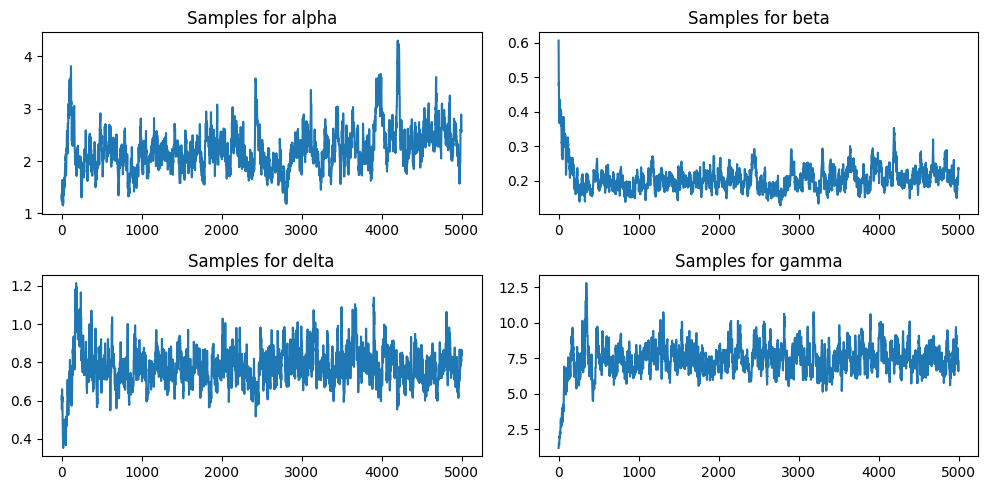

In [67]:
# Plot the results
plt.figure(figsize=(10, 5))
for i, param in enumerate(['alpha', 'beta', 'delta', 'gamma']):
    plt.subplot(2, 2, i + 1)
    plt.plot(jnp.exp(mh_samples[:,i]))
    plt.title(f'Samples for {param}')
    #plt.ylim((0,5))
plt.tight_layout()
plt.show()

In [59]:
log_likelihood_lv(jnp.array([mh_samples[-1,:]]))

Array([-10.71715836], dtype=float64)

In [ ]:
np.nan>np.abs(10**5)

False

In [29]:
log_likelihood_lv(jnp.array([params_current[-1,:]]))

Array([-10.567825], dtype=float64)

In [60]:
params_current[-1,:]

Array([ 1. , -0.9, -2.4,  0.9], dtype=float64)

In [61]:

latent_dist = posterior.predict(jnp.array([mh_samples[-1,:]]), train_data=D)
predictive_dist = posterior.likelihood(latent_dist)
mf = predictive_dist.mean().reshape(-1,1)
vf = predictive_dist.stddev().reshape(-1,1)
mf

Array([[7.25031483]], dtype=float64)

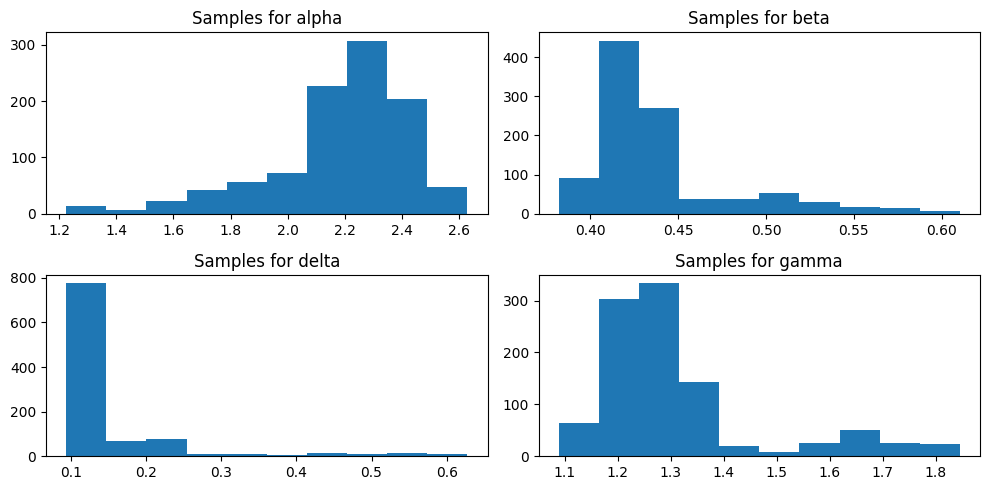

In [ ]:
# Plot the results
plt.figure(figsize=(10, 5))
for i, param in enumerate(['alpha', 'beta', 'delta', 'gamma']):
    plt.subplot(2, 2, i + 1)
    plt.hist(jnp.exp(mh_samples[:,i]))
    plt.title(f'Samples for {param}')
    #plt.ylim((0,5))
plt.tight_layout()
plt.show()

## Lotka Volterra

In [ ]:
# what is the lotka-volterra likelihood
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the Lotka-Volterra equations
def lotka_volterra(X, t, alpha, beta, delta, gamma):
    x, y = X
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]

# Generate synthetic data using known parameters
def generate_synthetic_data(true_params, initial_conditions, t):
    return odeint(lotka_volterra, initial_conditions, t, args=tuple(true_params))

# Define the likelihood function
def log_likelihood(log_params, t, data, initial_conditions):
    params=np.exp(log_params)
    alpha, beta, delta, gamma = params
    model = odeint(lotka_volterra, initial_conditions, t, args=(alpha, beta, delta, gamma))
    error = data - model
    return -np.sum(error**2) / 2

# Define the Metropolis-Hastings algorithm
def metropolis_hastings(log_likelihood, initial_params, t, data, initial_conditions, n_iterations, proposal_width):
    params = np.array(initial_params)
    log_likelihood_current = log_likelihood(params, t, data, initial_conditions)
    samples = [params]

    for i in range(n_iterations):
        # Propose new parameters
        params_new = params + (np.random.uniform(0,1, size=params.shape)-0.5)*proposal_width
        log_likelihood_new = log_likelihood(params_new, t, data, initial_conditions)

        # Acceptance criterion
        if np.random.rand() < np.exp(log_likelihood_new - log_likelihood_current):
            params = params_new
            log_likelihood_current = log_likelihood_new

        print(i)
        samples.append(params)

    return np.array(samples)




In [ ]:
# True parameters for generating synthetic data
true_params = [2.0, 0.1, 0.1, 1.5]
initial_conditions = [10, 5]
t = np.linspace(0, 50, 500)
data = generate_synthetic_data(true_params, initial_conditions, t)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


<ipython-input-6-9d0be5314d05>:37: RuntimeWarning: overflow encountered in exp
  if np.random.rand() < np.exp(log_likelihood_new - log_likelihood_current):


Streaming output truncated to the last 5000 lines.
5000
5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189

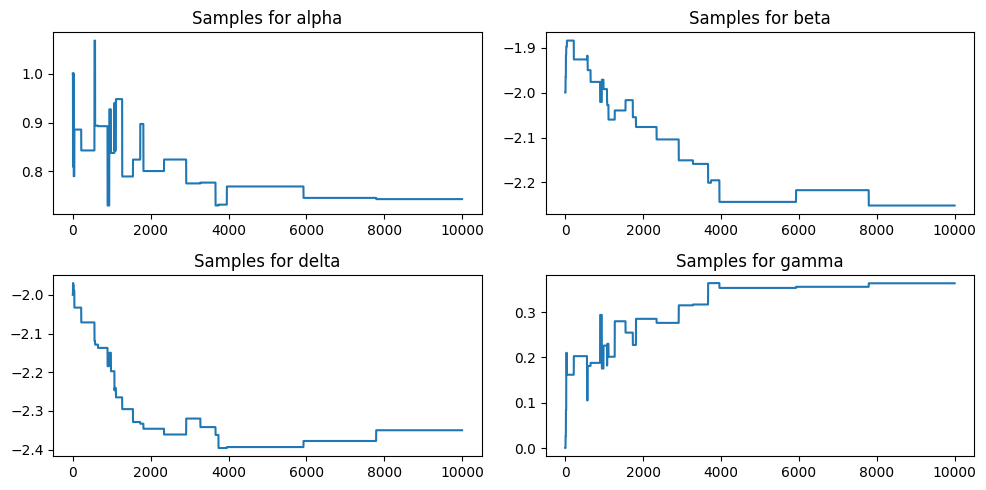

[2.10322658 0.10525787 0.09539323 1.43897243]


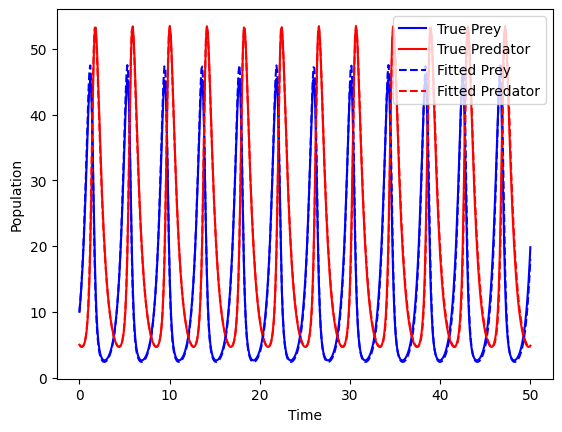

In [ ]:


# Initial guess for parameters
initial_params = [1.0, -2.0, -2.0, 0.0]
n_iterations = 10000
proposal_width = [0.5,0.1,0.1,0.5]

# Run the Metropolis-Hastings algorithm
samples = metropolis_hastings(log_likelihood, initial_params, t, data, initial_conditions, n_iterations, proposal_width)

# Plot the results
plt.figure(figsize=(10, 5))
for i, param in enumerate(['alpha', 'beta', 'delta', 'gamma']):
    plt.subplot(2, 2, i + 1)
    plt.plot(samples[:, i])
    plt.title(f'Samples for {param}')
plt.tight_layout()
plt.show()

# Plot the fitted model vs true data
best_params = samples[np.argmax([log_likelihood(p, t, data, initial_conditions) for p in samples])]
fitted_model = generate_synthetic_data(np.exp(best_params), initial_conditions, t)
print(np.exp(best_params))
plt.figure()
plt.plot(t, data[:, 0], 'b-', label='True Prey')
plt.plot(t, data[:, 1], 'r-', label='True Predator')
plt.plot(t, fitted_model[:, 0], 'b--', label='Fitted Prey')
plt.plot(t, fitted_model[:, 1], 'r--', label='Fitted Predator')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Population')
plt.show()
